***This notebook is based on the class notes of Foundation of Data Science in BGSE 2019-2020 academic year***

$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

In [1]:
%matplotlib inline
import matplotlib.pylab as plt

from utils.helper_functions import *

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from IPython.display import Image 
import pydotplus 
import graphviz
from missingpy import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
def plot_tree(clf, feature_names, target_names):
    dot_data = sklearn.tree.export_graphviz(clf, out_file=None, 
                             feature_names=feature_names,  
                             class_names= target_names,  
                             filled=True, rounded=True,  
                             special_characters=True) 
    return pydotplus.graph_from_dot_data(dot_data).create_png() 


# Linear models with tree-based features

$$f(\bx;\bb) = \sum_{m=1}^p \beta_m 1[\bx \in R_m]$$

if X belongs to certain class, class, multiplied by 1

where the $R_m$ are disjoint subsets of the input space defined by a binary tree, say splitting each variable on the median. 

For example say $p=2$ and we split each variable to the median, then there would be four regions: 
+ region 1: $x_1 < median(x_1)$ and $x_2 < median(x_2)$
+ region 2: $x_1 > median(x_1)$ and $x_2 < median(x_2)$
+ region 2: $x_1 < median(x_1)$ and $x_2 > median(x_2)$
+ region 2: $x_1 > median(x_1)$ and $x_2 > median(x_2)$

Below, there is a more generic partitioned space of 2 variables

However, there are (at least) two main problems with this approach:

1. Computational: for $p$ variables there are $2^p$ regions if we split each variable in its median, hence we quickly end up with massive number of features - and will overfit unless we take precautions 
2. Predictive: even if we have carefully preselected the input variables in terms of their relevance for prediction it might turn out that a few, or even most, are not useful for prediction, hence we should not be subdiving the population according to these variables. On the other hand, for those that are relevant for prediction, there is no good reason why the median, or any preselected quantile, provides a good split. We would like to learn from the data itself where to split each variable (if used at all in the model); and maybe in order to get a good predictive model we might have to split some variables several times. Which now feeds back into the "computational" problem since the  potential regions might be much larger than $2^p$.

# Tree based models: a first illustration

Tree-based models, and the associated learning algorithms for fitting them to data, address these two challenges and result in a non-linear (in the parameters as well as the inputs) model where the variables to be split and the split points are learned from data. 

In [2]:
dataset = pd.read_csv("./spam_small_train.csv")
X = dataset.drop('class', axis = 1)
y = dataset["class"]

# to print stats
feature_names = X.columns
class_labels = ["email", "spam"]
X.head()

word_freq_george  word_freq_you  word_freq_your  word_freq_hp  \
0               0.0           1.93            0.96           0.0   
1               0.0           3.47            1.59           0.0   
2               0.0           1.36            0.51           0.0   
3               0.0           3.18            0.31           0.0   
4               0.0           3.18            0.31           0.0   

   word_freq_free  word_freq_hpl  word_freq_our  word_freq_re  word_freq_edu  \
0            0.32            0.0           0.32          0.00           0.00   
1            0.14            0.0           0.14          0.00           0.00   
2            0.06            0.0           1.23          0.06           0.06   
3            0.31            0.0           0.63          0.00           0.00   
4            0.31            0.0           0.63          0.00           0.00   

   word_freq_remove  char_freq_!  
0              0.00        0.778  
1              0.21        0.372  
2              0.19        0.276  
3              0.31        0.137  
4              0.31        0.135

In [3]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_leaf_nodes=38, min_samples_split=59)
model.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=38,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=59,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

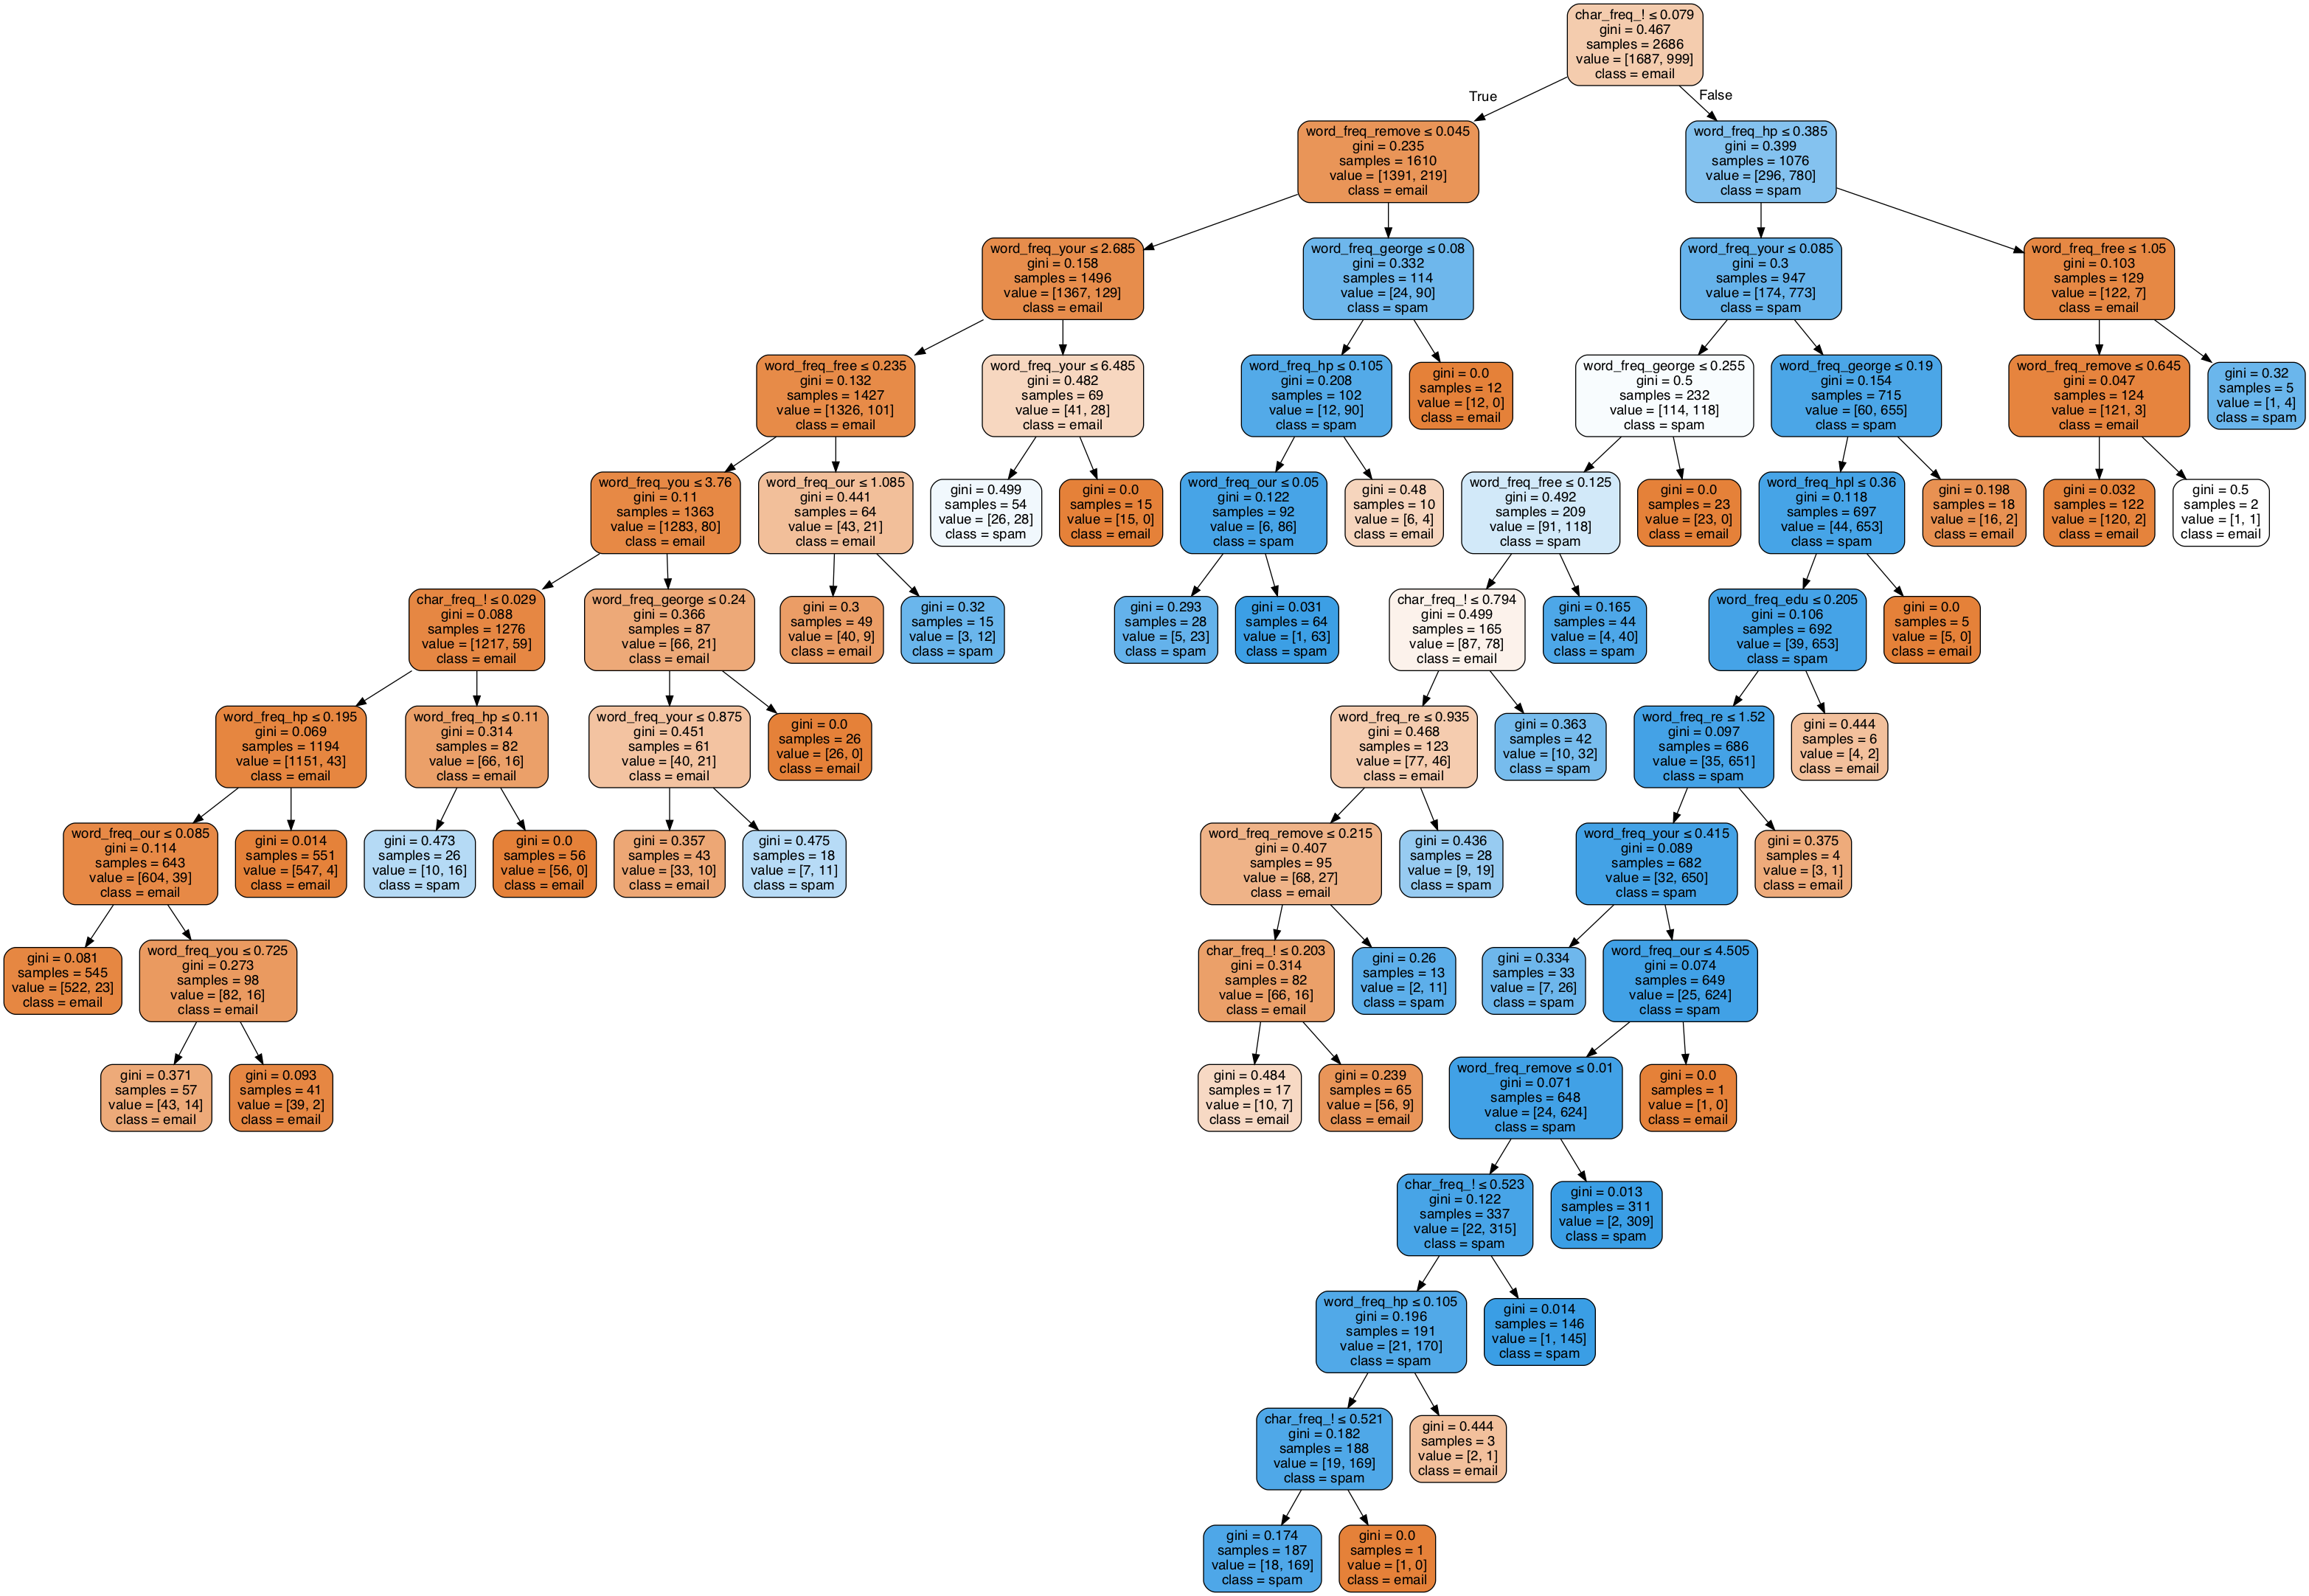

In [4]:
Image(plot_tree(model, feature_names, class_labels))

# Trees in Depth.

You start at root node, at depth 0 and this node asks if the char_freq lower than certain value if it is true you move to left child node. If its reather a leaf node it does not ask anymore questions and you stop there do a certain prediction.

If its a child node rather then leaf, it asks a another question, and you go on until it stops asking questions and do a prediction

- Samples: How many training instances it applies to, then divide those instances according to criteria
- Values: Divide these training instances according to criteria, for instance 1687 instances have char_freq lower than 0.079 and 999 higher.
- Gini measures impurity of a node, for instance if a certain criteria only applies to 1 class gini is zero.

Gini Coefficient given by;
$$G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2$$

For Example, take the initial left node;
$$G_{dept_1} = 1 - \left(\frac{1391}{1610}\right)^2 - \left(\frac{219}{1610}\right)^2 = 0.235$$

- Max depth represents the maximum depth our tree can split, for instance it is 2, there can be max of 2 child nodes and 4 leaf nodes. Sklearn uses CART algo, which only allows for a node to split in 2 different nodes. If the max_depth is 2; first root node splitted to 2 then if both of those nodes are not pure they split again, since max_depth = 2, it does not split more and we end up with 4 leaf nodes

How the model chooses feature and the threshold to do the splits?

- Model tries to choose feature and the thereshold that will produce lowest Gini, it does that by trying to minimize weighted average of left and right nodes, loss function given by:

$$l(feaeture, threshold) = \left(\frac{n_{left}}{n}\right) \cdot G_{left} + \left(\frac{n_{right}}{n}\right) \cdot G_{right}$$

- It follows same logic at each split, it stops when it reaches max_depth limit or if it cannot find any more splits that will reduce the Gini

- Algo compares all features at each split to find the feature that will give you purest split

# Regularization Hyperparameters

Decision Trees are the best examples of bias-variance trade-off, if we leave parameters unconstrined they will have unlimited degrees of freeedom and will fit the training data perfect, but will have really low generalization ability. Meaning, they will have really high variance but low bias.

Parameters, that can be restricted to avoid overfitting:

- max_depth: Max depth of the tree
- min_samples_split: minumum number of samples a node must have to split
- min_samples_leaf: minumum number of samples a leaf node needs to have: for instance a leaf node having 2 samples and 0 gini is clear overfitting
- min_weight_fraction_leaf: same as min samples leaf, but expressed as a weight of total samples
- max_leaf_nodes : Maximum number of leaf nodes, tree allowed to have, having too many leaf nodes is a sign of overfitting
- max_features: Max number of features evaluated to split a child node. Leads to a more constrained model.

Increasing min* regulizers and decreasing max* regulizers will increase the regularization of the model


In [5]:
spam_test = pd.read_csv("./spam_small_test.csv")
Xtest = spam_test.drop("class",axis=1)
ytest = spam_test["class"]
pred = model.predict_proba(X)
test_pred = model.predict_proba(Xtest)
test_pred_class = model.predict(Xtest)

In [6]:
spam_test["spam_prob"] = test_pred[:, 1]

***We observe that the model predicts 'spam' or 'email' with apparently high confidence on its results (probabilities close to 0 or 1, few points in between).***

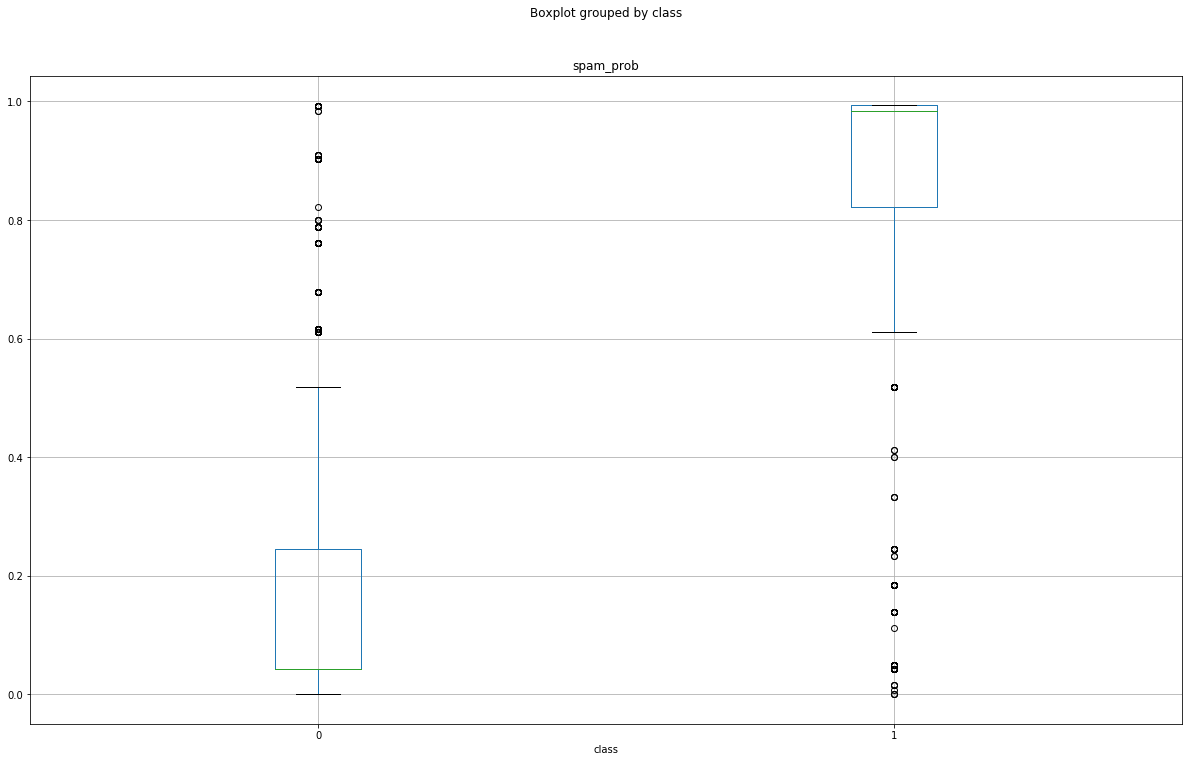

In [7]:
spam_test.boxplot(column="spam_prob", by="class", figsize=(20,12))

# AUC recap

Refer to Classification notebook.

# Overfitting in absence of Reg.

***Notice the difference between Train ROC and Test ROC***

***Train ROC***

AUC:  0.972200119503024


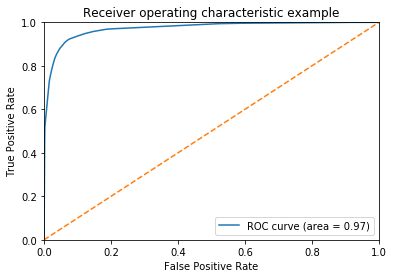

In [8]:
# Custom plot function
get_auc(y, pred, class_labels, column=1, plot=True) # Helper function

***Test ROC***

AUC:  0.9088468428123602


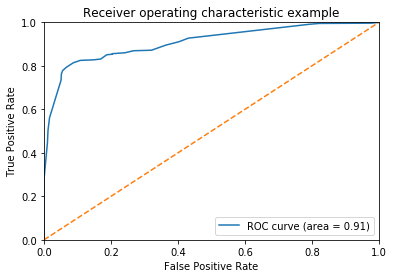

In [9]:
get_auc(ytest, test_pred, class_labels, column=1, plot=True) # Helper function

There are clear signs of overfitting here, because AUC is 1 for training set, but clearly smaller for test set. When the AUC or Prec-Recall extremly high for training sample, generally it is a sign of something is not right.

# Complexity, accuracy and overfitting

Here we show *overfitting* risk: allowing an increasing number of final leaves in our tree, we increase the accuracy on training data, but not necessarily increase accuracy when applying to new (test) data. 

By grid-searching the hyperparameter 'max_leaf_nodes', we can find optimum value to avoid overfitting.

max_leaf_nodes : Max number of final dec. nodes, increasing it decreases the regr. thus increase the variance and the decrease the bias.

***Notice that after some point increasing model variance "max_leaf_nodes" start to decrease test acc. meaning model cannot generalize on unseen data***


Best accuracy:  0.8718619246861925 at max_leaf_nodes =  60


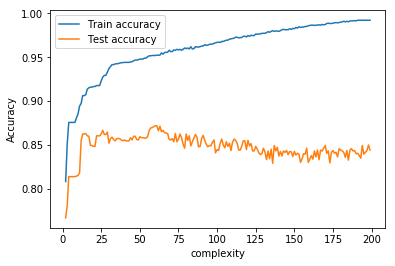

In [10]:
# some sklearn tools
from sklearn.metrics import accuracy_score

# keep the results in a list
complexity_value = [] # will store max_leaf_nodes for each trial
test_accuracy = [] # will store test_acc for each "max_leaf_nodes"
train_accuracy = [] # will store train acc.

# loop through possible values of max_leaf_nodes
for max_leaf_nodes in range (2, 200): # loop over 198 "max_leaf_nodes"
    model  = DecisionTreeClassifier(criterion = "entropy", max_leaf_nodes=max_leaf_nodes)  # create the model
    model.fit(X, y) # fit it
    
    #predict both on train and test set
    y_pred = model.predict(Xtest) # predict test data
    y_pred_train = model.predict(X) # predict train data
    
    # store the data to be used for plotting
    train_accuracy.append(accuracy_score(y, y_pred_train)) # store the train acc.
    test_accuracy.append(accuracy_score(ytest, y_pred)) # store the test acc.
    complexity_value.append(max_leaf_nodes) # store the corresponding "max_leaf_nodes"
    

# max test acc. and its corresponding "max_leaf_nodes"
print ("Best accuracy: ", max(test_accuracy), 'at max_leaf_nodes = ', complexity_value[np.argmax(test_accuracy)])
# plot acc.s against all "max_leaf_nodes"
plt.plot(complexity_value, train_accuracy, label='Train accuracy')
plt.plot(complexity_value, test_accuracy, label='Test accuracy')
plt.xlabel("complexity")
plt.ylabel("Accuracy")
plt.legend()

# Implicit variable selection and scoring

The model and algorithm effectively do a variable selection, since some variables drop out (never chosen for split) and a scoring of those that enter the model.

In [11]:
model  = DecisionTreeClassifier(max_leaf_nodes=20) 
model.fit(X, y)
#important_features = pd.DataFrame(model.feature_importances_/model.feature_importances_.max() ,index=X.columns, columns=['importance'])
# it is common to normalize by the importance of the highest
#important_features.sort_values('importance', ascending=False)
pd.DataFrame(model.feature_importances_).sort_values(by=0, ascending=False)

0
10  0.504737
3   0.145700
9   0.126294
2   0.087578
0   0.069691
4   0.024426
7   0.015308
5   0.009770
6   0.009642
1   0.006855
8   0.000000

# Bootstrapping for feature importance and Parameter Evaluation

***Random Forrest follows a similar process***

depth  score_char
count  100.000000       100.0
mean    30.930000         1.0
std      6.299359         0.0
min     13.000000         1.0
25%     27.000000         1.0
50%     32.000000         1.0
75%     36.000000         1.0
max     39.000000         1.0

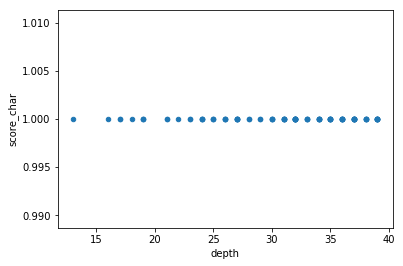

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
test_accuracy_argmax = [] # the maximal test accuracy achieved for each split
importance_char = [] # the variable char_! importance
optim_param = []
for bootsam in np.arange(100):
    # split randomly dataset; do not fix the seed to see variation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # Randomly split data
    #
    # First search for depth 
    test_accuracy = [] # to store the test accuracy for each max_leaf, we will set this to empty list for each bootstrap sample
    complexity_value = [] # max_leaf
    for max_leaf_nodes in np.arange (5, 40): 
        model  = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes) # defining the model
        model.fit(X_train, y_train) # fitting it
        y_pred = model.predict(X_test) # predicting it
        test_accuracy.append(accuracy_score(y_test, y_pred)) # store accuracy for each max_leaf
        complexity_value.append(max_leaf_nodes) # also number of max_leaf
    test_accuracy_argmax.append(complexity_value[np.argmax(test_accuracy)]) # get the max score for 1 bag
    # Now we stored best estimator and its score for 1 bootstrap sample
    # Then find and store the relative importance of fare for the chosen tree
    model  = DecisionTreeClassifier(max_leaf_nodes=complexity_value[np.argmax(test_accuracy)]) # fit the model with best param
    model.fit(X_train, y_train)
    important_features = pd.DataFrame(model.feature_importances_/model.feature_importances_.max() ,
                                      index=X.columns, columns=['importance']) # calculate feature importance with best param
     # for a particular bootstrap sample
    # Each feature scaled by most important one, the one has value of 1 is the most important
    importance_char.append(important_features.loc["char_freq_!",:].values[0]) # get the value for char_freq
    optim_param.append(complexity_value[np.argmax(test_accuracy)])
# Print the results in a convenient manner
result =pd.DataFrame(test_accuracy_argmax,columns=["depth"])
result["score_char"] = importance_char
result.plot(x="depth",y="score_char",kind="scatter")

result.describe()

***Notice that opt. param. changes quite a lot from sample to sample, trees are sensitive to different data-sets***

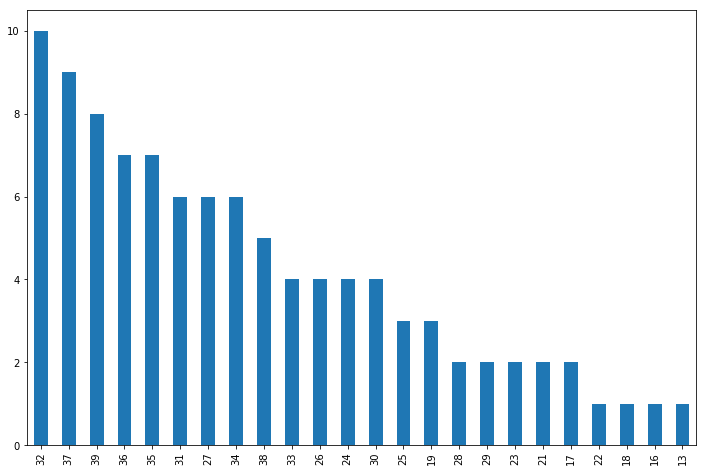

In [13]:
pd.Series(optim_param).value_counts().plot(kind="bar", figsize=(12,8))

This is typical of an estimator with high variance

B(ootstrap) AGG(regation) ING tries to estimate the population-averaged estimator by boostrapping the procedure and averaging across datasets. The resultant learned function is not anymore a decision tree, but a linear combination of trees. This makes bagging an ensemble method - effectively a *model averaging* approach. 

Bagging allows same model to trained on different data sets by using bootstraping, as we saw from above bootstrapping, best performing parameters of the estimator change a lot data-set to data-set. Now imagine you can train 500 trees on different data-sets than average over their predictions. By doing so bias of the model preserved by it has lower variance thus higher generalazation ability.

When sampling is performed with replacement, this method is called bagging1 (short for bootstrap aggregating). When sampling is performed without replacement, it is called pasting

In other words, both bagging and pasting allow training instances to be sampled several
times across multiple predictors, but only bagging allows training instances to be
sampled several times for the same predictor.

# Random forests in sklearn

Random Forrest is a random patched metohd, it has all the parameters of a decision tree plus some extra to control randomness in the model

Only difference is
- n_estimators : Number of the trees in the model

Other than that, good thing to know is trees inside random forrest does not look for best feature to split a node, it looks for a best feature from random subset of features. This creates diversity between trees and reduce the correlation between trees thus reduces variance with a cost of small increase in bias

## Feature Importance

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

np.random.seed(31415) # impose random seed for reproducibility

dataset = pd.read_csv("./spam_small_train.csv")
X = dataset.drop(['class'], axis = 1)
y = dataset["class"]

# to print stats
feature_names = X.columns
class_labels = ["email", "spam"]


forest = RandomForestClassifier(n_estimators=20)
scores = cross_val_score(forest, X, y, cv=5) # Cross validated accuracy, uses default score of model
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


importances = forest.fit(X,y).feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)




Accuracy: 0.92 (+/- 0.01)


char_freq_!         1.000000
word_freq_free      0.613420
word_freq_your      0.579099
word_freq_remove    0.573663
word_freq_hp        0.496748
word_freq_you       0.428726
word_freq_george    0.287131
word_freq_our       0.237809
word_freq_hpl       0.183887
word_freq_re        0.144681
word_freq_edu       0.042356
dtype: float64

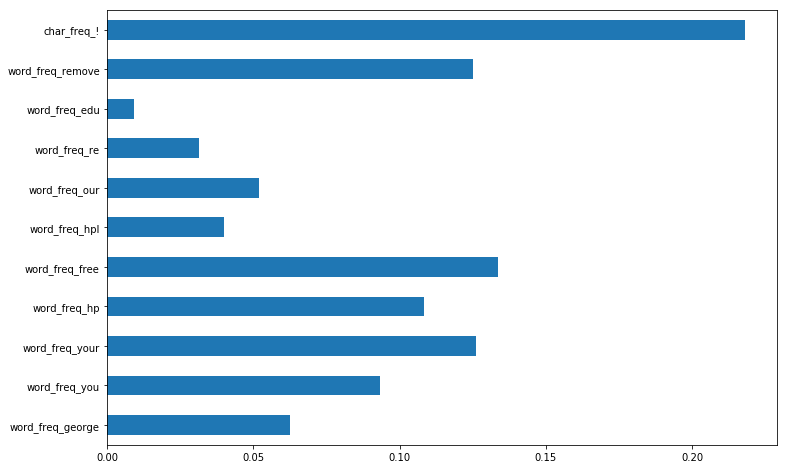

In [15]:
feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh', figsize=(12, 8))

# Boosting

### Boosting and additive models

The essense of the method is as follows. Say we have models $f_m(x,\beta_m)$, for example each could be a tree-based model. We wish to fit a linear combination of those to data, i.e., 

$$
f(x,\theta,\beta) = \sum_{m=1}^p \theta_m f_m(x,\beta_m)
$$

where $f_m$ stands for the *m_th* weak classifier and $\theta_m$ is the corresponding weight.

m_th weak classifier becuase we are taking linear combination of several classifiers.

Following the fundamental principles of machine learning modelling we also need a data-function mismatch component (loss function) in the model, for example: 

+ in regression $L(y_i,f(x_i)) = (y_i-f(x_i))^2$ is the deviance (MSE)
+ in classification, with output coded as $y_i \in \{+1,-1\}$, $L(y_i,f(x_i)) = \log(1+e^{-y_i f(x_i,\beta)})$ is also the ***negative log-likelihood***.

Therefore, to learn such additive model from data we need to solve 

$$
\arg \min_{\theta,\beta} \sum_{i=1}^n L\left( y_i, \sum_{m=1}^p \theta_m f_m(x,\beta_m) \right)
$$

In other words, we need to find threshold cuts, and weight of each classifier, so that overall we minimize the loss function.


iterative optimization algorithms:

Since the optimization is non-convex we can cannot get the parameters with a FOC. thus we take small gradient steps to reach to min. Meaning, we start by settin parameters randomly then we calculate the gradient of the function and we take small gradient steps. We take partial derivative of the function with respect to each parameter we multiply this by small learning rate and we calculate loss function again then we repeat this until we do not see any improvement in the loss function.

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

np.random.seed(3123) # impose random seed for reproducibility


X = dataset.drop(['class','word_freq_hpl','word_freq_re','word_freq_edu','word_freq_you','word_freq_our'], axis = 1)
feature_names = X.columns

tree = GradientBoostingClassifier(n_estimators=50)
scores = cross_val_score(tree, X, y, cv=10,  scoring='roc_auc')
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

importance = tree.fit(X,y).feature_importances_
important_features = pd.Series(data=importance/importance.max() ,index=feature_names)
important_features.sort_values(ascending=False)

Accuracy: 0.967 (+/- 0.022)


char_freq_!         1.000000
word_freq_hp        0.433249
word_freq_remove    0.310799
word_freq_your      0.225922
word_freq_free      0.208043
word_freq_george    0.186277
dtype: float64

# Models
## CART (single tree)
Use *sklearn* function $DecisionTreeClassifier$ for classification, or $DecisionTreeRegressor$ for regression. These models are simpler to understand and explore but typically yield worse results than the ones based on 'multiple tree' approach. Some interesting parameters  to tune (for classification) are:
+ *max_depth*: Number of levels in a tree
+ *min_samples_split*: Minimum number of samples left to try a new split
+ *min_samples_leaf*: Minimum number of samples allowed in a leaf
+ *min_impurity_decrease*: Don't accept the split if we don't reach a minimum decrease in impurity
+ *min_impurity_split*: Early stop criteria, don't split if mininum impurity has been reached
+ *class_weight*: Use 'balanced' if classes are unbalanced.


## Random forest
Use *sklearn* function $RandomForestClassifier$ for classification, or $RandomForestRegressor$ for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *max_features*: Number of features to consider when looking for the best split. If less than 100%, this intruduces stochasticity.
+ *boostrap*: Keep default 'True' to allow boostrapping the sample for each tree, useful to prevent overfitting
+ *max_depth*, *min_samples_split*, *min_impurity_decrease*, *min_impurity_split*, *class_weight*: Similar to CART


## AdaBoost

AdaBoost works like building trees 1 by 1, each wrong predictions weight increase when we move on to next tree and next tree tries to minimize loss function by giving more weight to those instances. 
 

Use *sklearn* function $AdaBoostClassifier$ for classification, or $AdaBoostRegressor$ for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *learning_rate*: Intensity of the re-weighting (boosting) each time we build a new tree.
+ 'base_estimator': Weak learner, by default 'DecisionTreeClassifier(max_depth=1)', but one can for instance increase depth to check if this helps.

## GradientBoosting (GBM)
Use *sklearn* function $GradientBoostingClassifier$ for classification, or $GradientBoostingRegressor$ for regression. Main parameters are:
+ *n_estimators*: Number of trees to build
+ *subsample*: Percentage of samples to use for every tree.
+ *learning_rate*: similar to AdaBoost
+ *max_features*,*max_depth*, *min_samples_split*, *min_impurity_decrease*, *min_impurity_split*, *class_weight*: Similar to random forest

## Extreme Gradient Boosting (XGBoost)
Use *xgboost* package and follow documentation at https://xgboost.readthedocs.io/en/latest/python/

Main functions are $xgboost.XGBClassifier$ or $xgboost.XGBRegressor$, which are an API to be used with *sklearn*.

Main parameters are:
+ *gamma*: similar to min_impurity_decrease. Minimum loss reduction required to make a further partition on a leaf node of the tree.
+ *colsample_bytree*:  Percentage of features to consider when constructing each tree.
+ *reg_alpha*:  L1 regularization term on weights to control overfitting
+ *reg_lambda*: L2 regularization term on weights to control overtiffing
+ *n_estimators*,*subsample*, *learning_rate*,*max_depth*: Similar to Gradient Boosting. 

## Other MART (Multiple Additive Regression Trees) models:
+ *ligthgbm* package: Computationally faster than GBM, https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
+ *catboost* package: Computationally faster than GBM, allows using GPU, https://github.com/catboost/catboost and https://catboost.ai/
+ Extremely Randomized Trees: Similar to random forest but optimization of splits is based on discrete random thresholds instead of exploring the entire space, so it's faster (and sometimes more accurate since is less prone to overfit). Use *sklearn* function $ExtraTreesClassifier$ or *ExtraTreesRegressor*

## Hyperparameter optimization
Use *sklearn* functions such as $GridSearchCV$ or $RandomizedSearchCV$. See example above in random forest section.

# Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train.csv*) consist of a list of features plus the resulting $parcelvalue$, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and $transactiondate$ is the date when the property was effectively sold. Properties are defined by $lotid$, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you don't have to use $totaltaxvalue$, $buildvalue$ or $landvalue$, because they are closely correlated with the final value to predict.

+ Using this data build a predictive model for $parcelvalue$ that corresponds to the category of 'decission trees' (e.g. CART, random forest, ada-boost, gradient boosting)
+ Try a first quick implementation, then try to optimize hyperparameters
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus1: Try an approach to fill NA without removing features or observations, and check improvements.
+ Bonus2: Try more than one type of model and compare results, both in terms of accuracy, feature selection, and bias/variance tradeoof (e.g. random forest vs gradient boosting).
+ Bonus3: Compare with other types of models that you already run (e.g. linear).

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Removing features that have more than 40% of missing data
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features
4. *Build* your model and test it on the same input data
5. Assess expected accuracy using *cross-validation*
6. Report variable *importance*
7. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.


In [17]:
! pip install category_encoders
!pip install missingpy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/Users/guneykan/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _dep_map
    return self.__dep_map
  File "/Users/guneykan/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/guneykan/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3003, in _parsed_pkg_info
    return self._pkg_info
  File "/Users/guneykan/anaconda3/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gu

## Initial Pre-Process

In [18]:
df = pd.read_csv("Regression_Supervised_Train.csv")

***Removing data that has NaN more than 40%***

In [19]:
df_drop_cols = []
for a in df.columns:
    if len(df[a][df[a].isna()])/len(df[a]) >= 0.4:
        df_drop_cols.append(a)
df_new = df.drop(df_drop_cols, axis=1)

***Dropping variables that are highly correlated with the target(taxval, buildval, landval)***

In [20]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83944 entries, 0 to 83943
Data columns (total 25 columns):
lotid              83944 non-null int64
logerror           83944 non-null float64
transactiondate    83944 non-null object
numbath            83929 non-null float64
numbedroom         83929 non-null float64
qualitybuild       53623 non-null float64
finishedarea       79738 non-null float64
countycode         83929 non-null float64
numfireplace       83944 non-null int64
numfullbath        83029 non-null float64
heatingtype        52916 non-null float64
latitude           83929 non-null float64
longitude          83929 non-null float64
lotarea            74695 non-null float64
citycode           82266 non-null float64
countycode2        83929 non-null float64
regioncode         83887 non-null float64
roomnum            83929 non-null float64
unitnum            54583 non-null float64
year               83401 non-null float64
buildvalue         83672 non-null float64
parcelvalue   

In [21]:
df_new = df_new.drop(["totaltaxvalue", "buildvalue", "landvalue"], axis=1)

***Converting date to a feature and we are replacing year col with the year from trans.date***

In [22]:
df_new["month"] = pd.Series(pd.to_datetime(df_new["transactiondate"]).map(lambda x: x.strftime('%m')), dtype="int16")
df_new["day"] = pd.Series(pd.to_datetime(df_new["transactiondate"]).map(lambda x: x.strftime('%d')), dtype="int16")
df_new["year"] = pd.Series(pd.to_datetime(df_new["transactiondate"]).map(lambda x: x.strftime('%y')), dtype="int16")
df_new = df_new.drop(["transactiondate"], axis=1)

## NaN Process

***A side note; This section and following 2 sections I experimented a lot in terms of interpolation but models did not perform better actually they performed worse. So it is better to not interpolate Categ. features (at least do not use KNN, maybe SVM or K-means would work) when too many data points are missing. It is ok to interpolate cont. features it gives a slide improvement, as long as it does not change the true distr. of the data. Its better to use one-hot-encoding over binary encoding, this does not apply to month and day, it is better to encode month and day with cos and sin transformation. Tree based models do not require dummy variable approach but we still do it as practice***

### First Check if any of the Cols are same in the data

In [23]:
df_new.describe().loc["mean"].sort_values()

longitude      -1.181997e+08
logerror        1.453452e-02
numfireplace    1.252621e-01
unitnum         1.110529e+00
roomnum         1.474187e+00
numfullbath     2.245709e+00
numbath         2.288744e+00
numbedroom      3.042107e+00
heatingtype     3.933593e+00
month           5.481357e+00
qualitybuild    6.018817e+00
day             1.642627e+01
year            1.646440e+01
finishedarea    1.752444e+03
taxyear         2.015464e+03
countycode2     2.529991e+03
countycode      6.048746e+03
lotarea         2.969584e+04
citycode        3.355747e+04
regioncode      9.657443e+04
parcelvalue     4.718071e+05
lotid           1.298265e+07
latitude        3.400659e+07
Name: mean, dtype: float64

### Storing all the features that has NaNs

In [24]:
nulls = []
for a in df_new.columns:
  if df_new[a].isnull().any() == True:
    nulls.append(a)
nulls

['numbath',
 'numbedroom',
 'qualitybuild',
 'finishedarea',
 'countycode',
 'numfullbath',
 'heatingtype',
 'latitude',
 'longitude',
 'lotarea',
 'citycode',
 'countycode2',
 'regioncode',
 'roomnum',
 'unitnum',
 'parcelvalue',
 'taxyear']

### Identify Categ. Vars.

In [25]:
df_new.nunique()

lotid           83253
logerror        40316
numbath            21
numbedroom         17
qualitybuild       12
finishedarea     4923
countycode          3
numfireplace        6
numfullbath        12
heatingtype        11
latitude        68384
longitude       66729
lotarea         19495
citycode          177
countycode2         3
regioncode        389
roomnum            16
unitnum             9
year                2
parcelvalue     57975
taxyear             2
month              12
day                31
dtype: int64

In [26]:
# identify cat vars
cat_vars = []
for a in df_new.columns:
  if df_new.nunique()[a] <= 389:
    cat_vars.append(a)
  else:
    next
cat_vars = cat_vars[:-2] # we will transform day and month differently
cat_vars

['numbath',
 'numbedroom',
 'qualitybuild',
 'countycode',
 'numfireplace',
 'numfullbath',
 'heatingtype',
 'citycode',
 'countycode2',
 'regioncode',
 'roomnum',
 'unitnum',
 'year',
 'taxyear']

### Seperating Categ. and Cont. Vars. that has NaNs

In [27]:
cat_nans = []
cont_nans = []
for a in nulls:
  if a in cat_vars:
    cat_nans.append(a)
  else:
    cont_nans.append(a)

print(cat_nans)
print(cont_nans)

['numbath', 'numbedroom', 'qualitybuild', 'countycode', 'numfullbath', 'heatingtype', 'citycode', 'countycode2', 'regioncode', 'roomnum', 'unitnum', 'taxyear']
['finishedarea', 'latitude', 'longitude', 'lotarea', 'parcelvalue']


### Check distr. of NaN cont. features

/Users/guneykan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


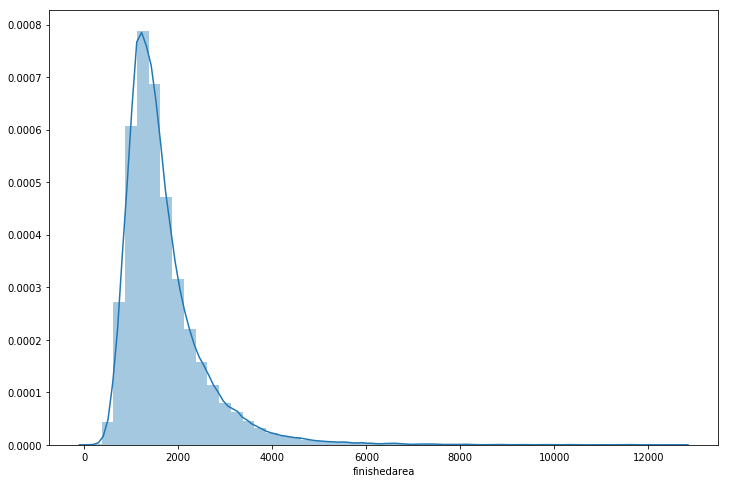

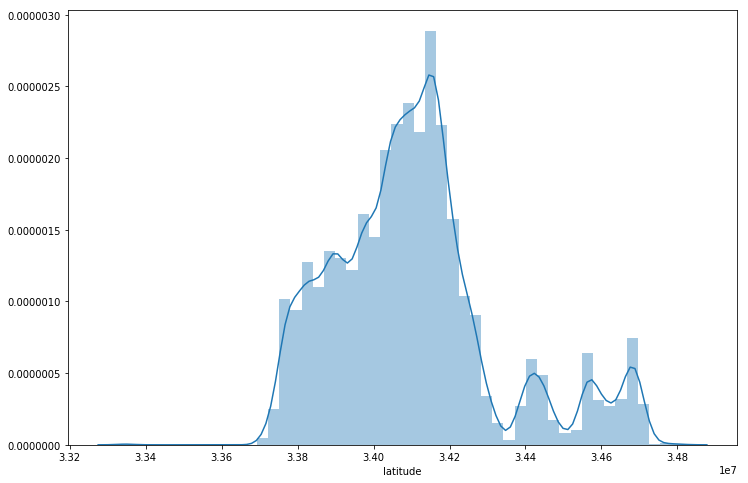

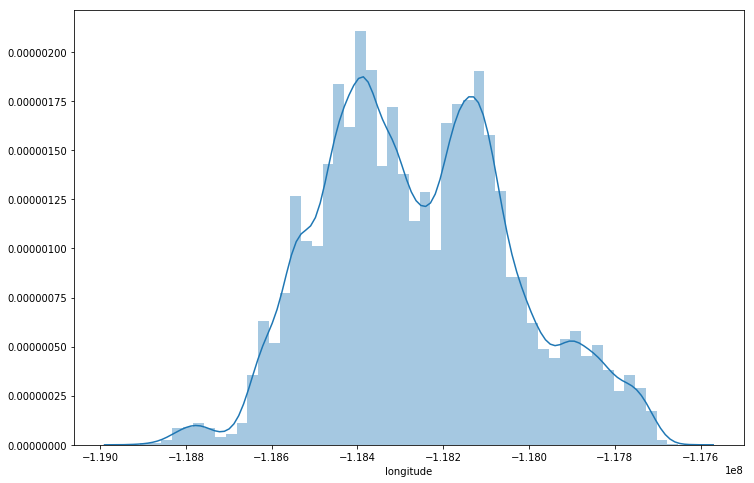

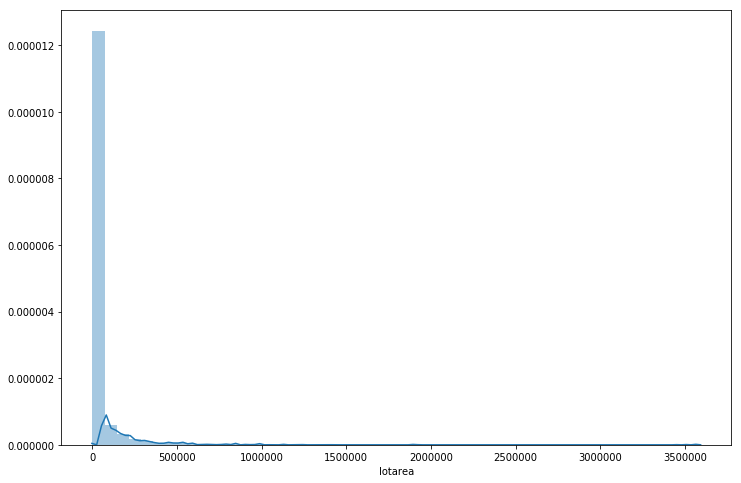

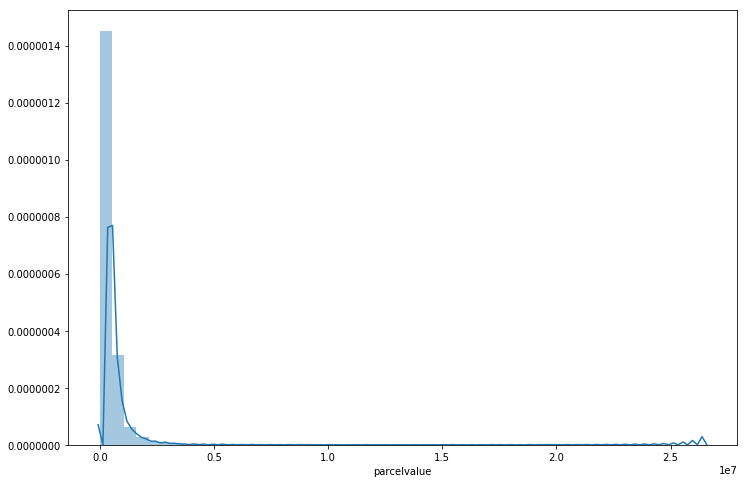

In [28]:
# True Dist
from scipy import stats
for a in cont_nans:
    plt.figure(figsize=(12,8))
    sns.distplot(df_new.dropna()[a])

### Interpolated Dist.

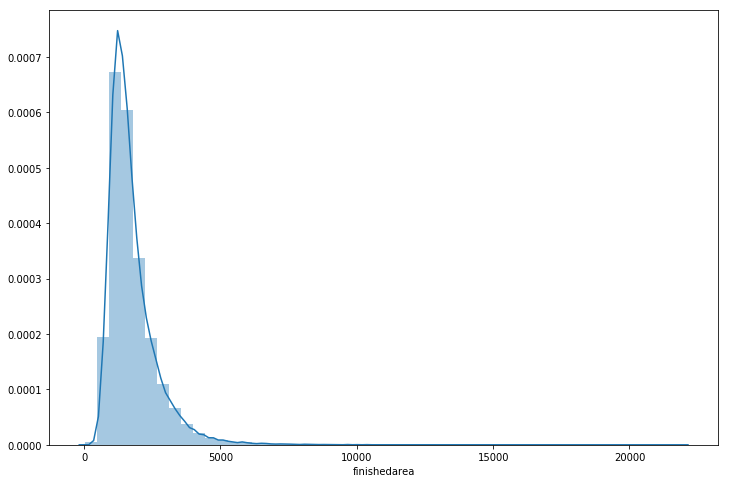

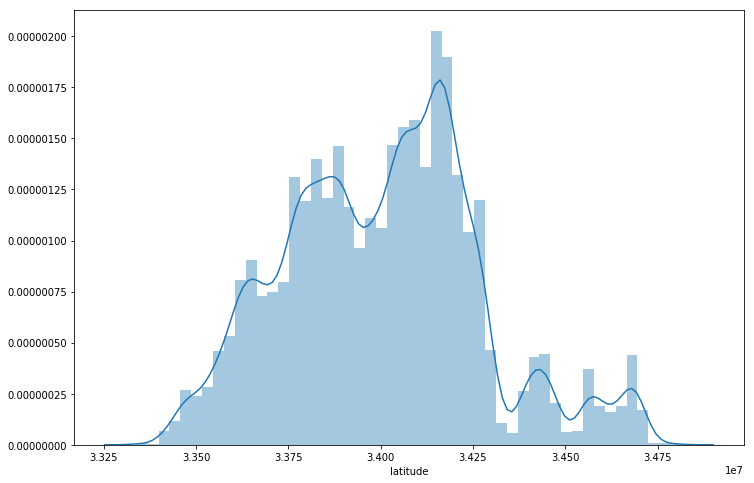

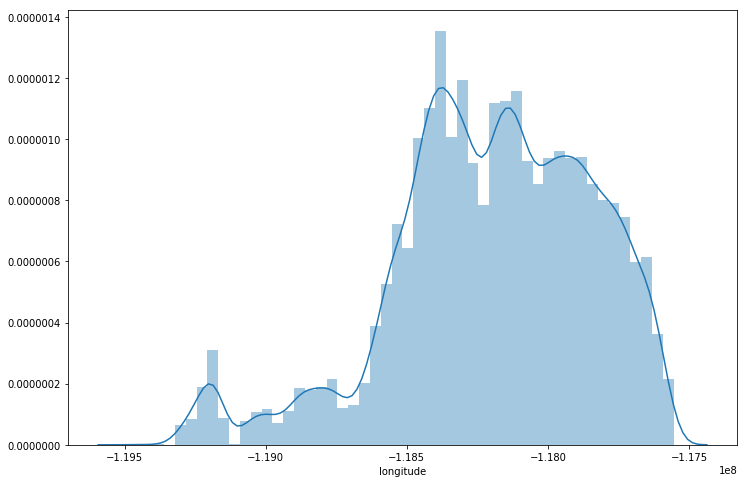

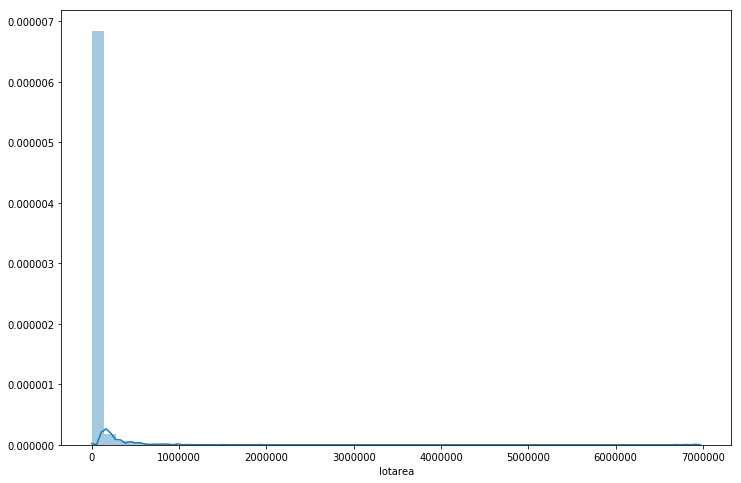

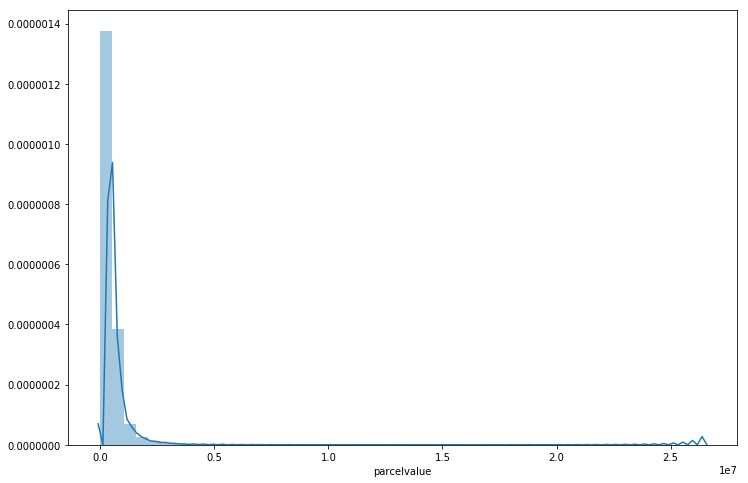

In [29]:
for a in cont_nans:
    plt.figure(figsize=(12,8))
    sns.distplot(df_new[a].interpolate("pchip"))

### Interpolate the Cont. features

In [30]:
for a in cont_nans:
  df_new[a] = df_new[a].interpolate("pchip")

In [31]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83944 entries, 0 to 83943
Data columns (total 23 columns):
lotid           83944 non-null int64
logerror        83944 non-null float64
numbath         83929 non-null float64
numbedroom      83929 non-null float64
qualitybuild    53623 non-null float64
finishedarea    83944 non-null float64
countycode      83929 non-null float64
numfireplace    83944 non-null int64
numfullbath     83029 non-null float64
heatingtype     52916 non-null float64
latitude        83944 non-null float64
longitude       83944 non-null float64
lotarea         83944 non-null float64
citycode        82266 non-null float64
countycode2     83929 non-null float64
regioncode      83887 non-null float64
roomnum         83929 non-null float64
unitnum         54583 non-null float64
year            83944 non-null int16
parcelvalue     83944 non-null float64
taxyear         83929 non-null float64
month           83944 non-null int16
day             83944 non-null int16
dtyp

### KNN imputing for Cat. Vars.

***We are going to drop ["qualitybuild", "heatingtype", "unitnum"], my computer crashes when I try to impute 30k NaNs***

***Check the Relationship before imputing***

/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg

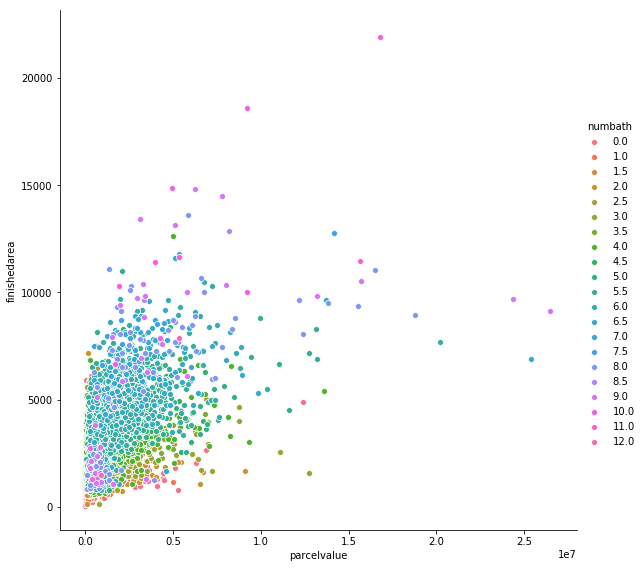

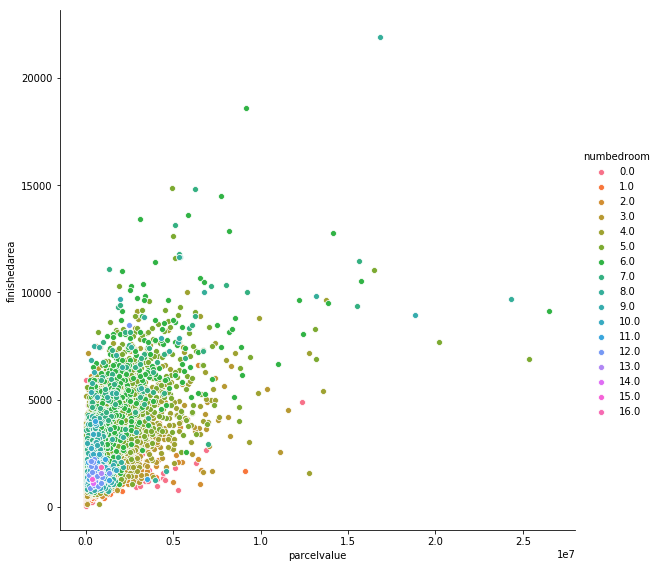

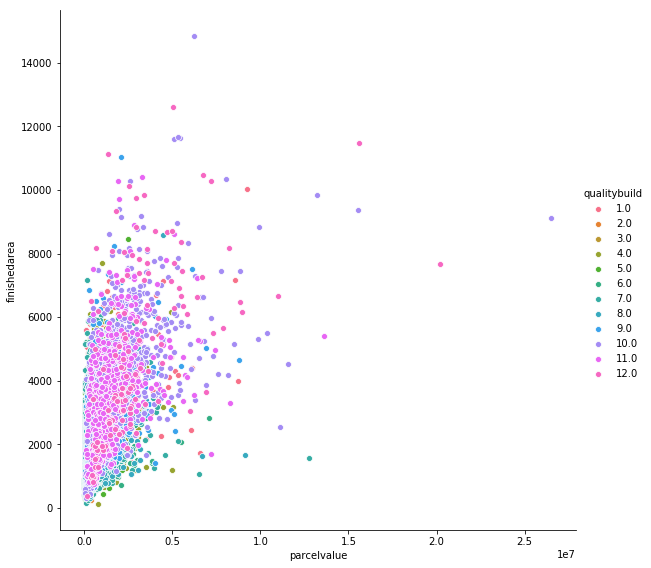

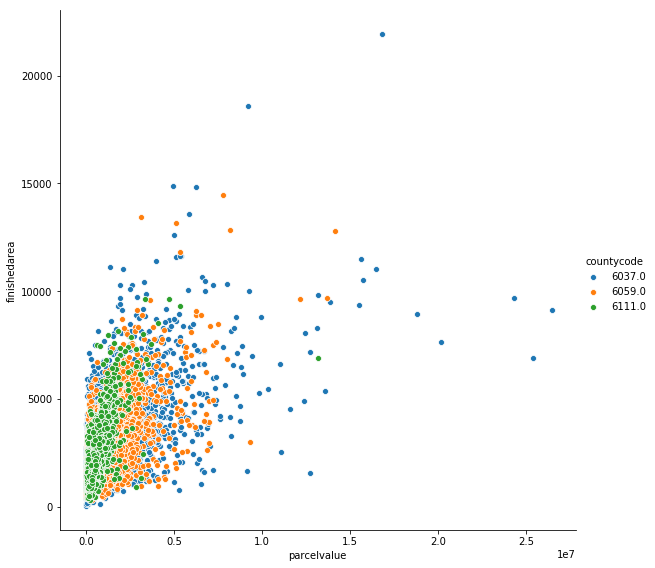

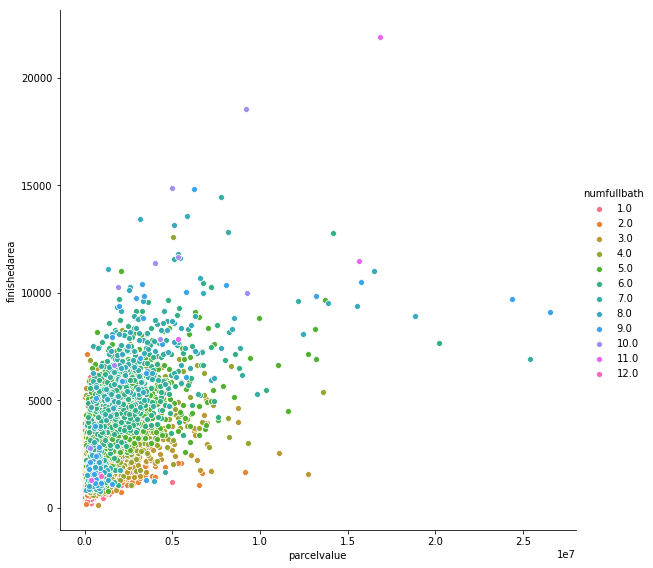

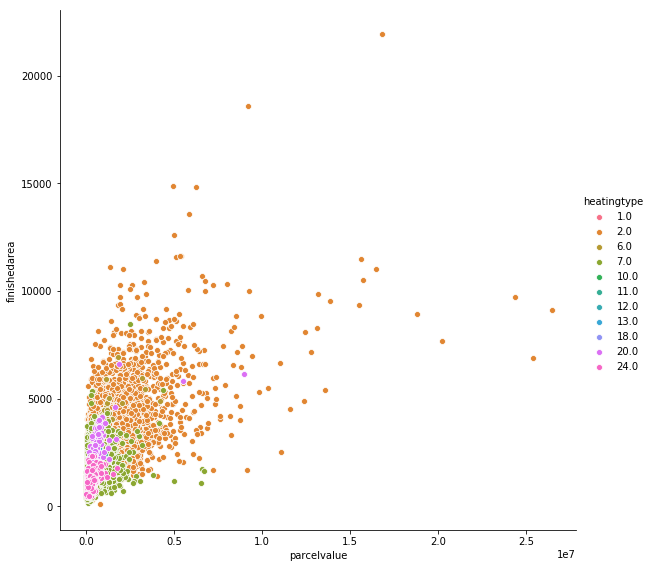

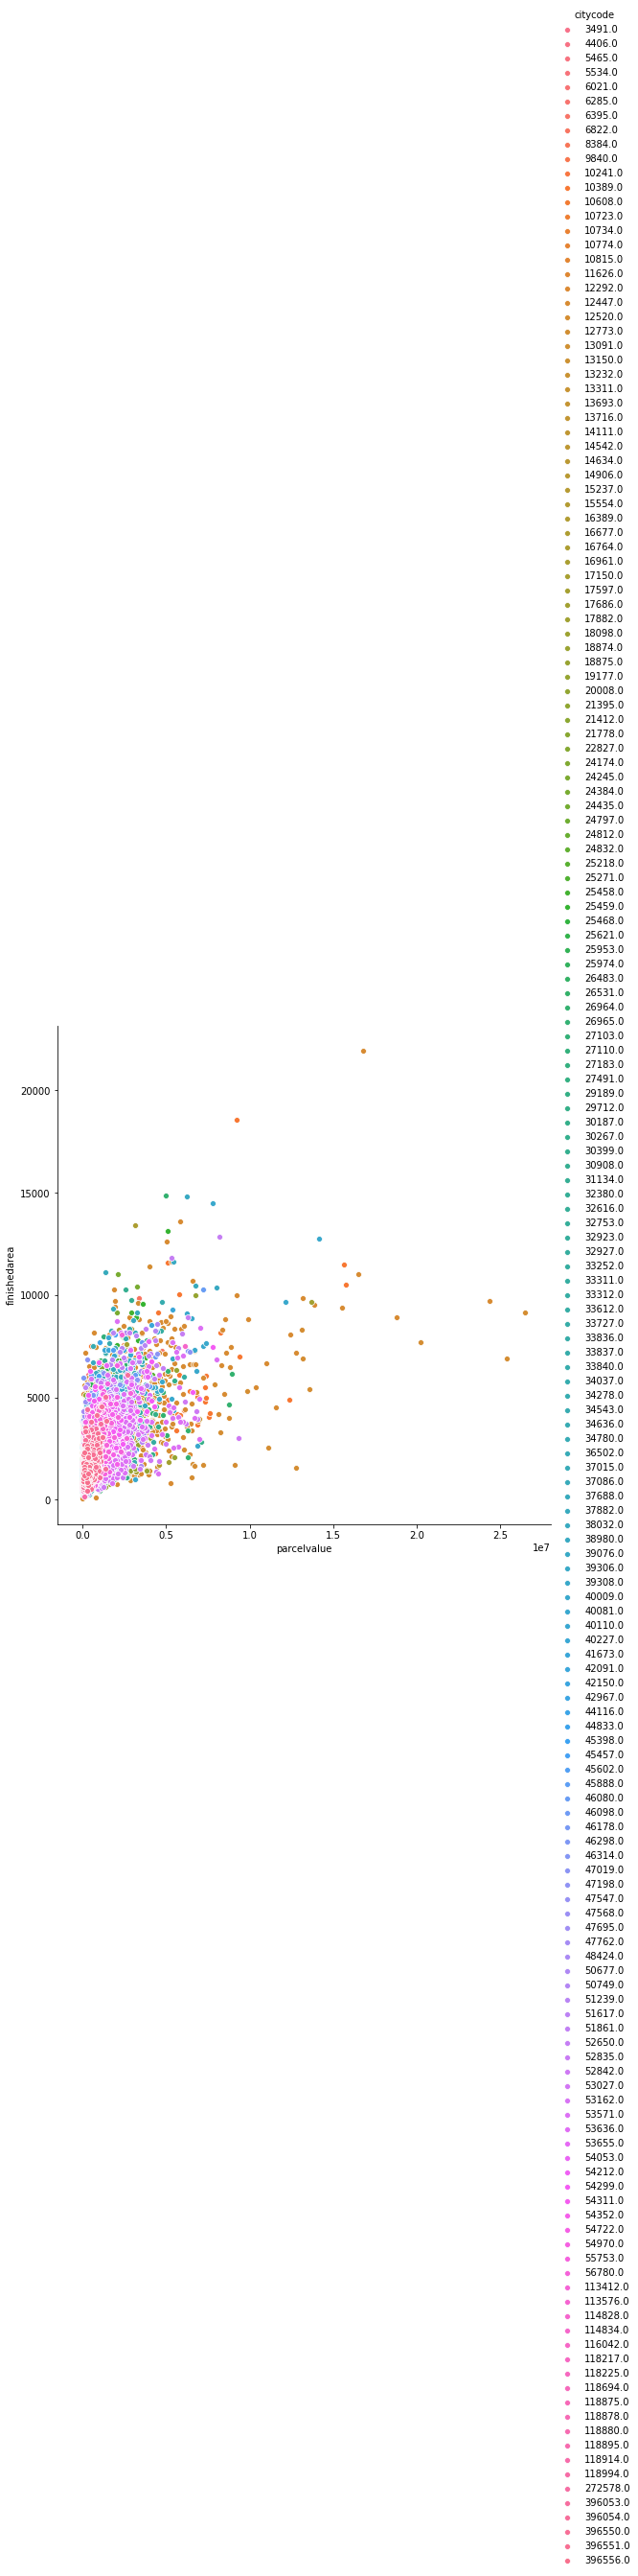

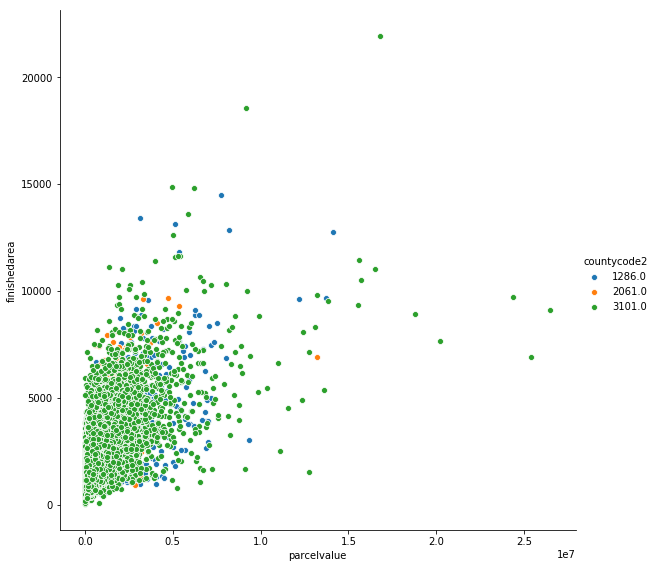

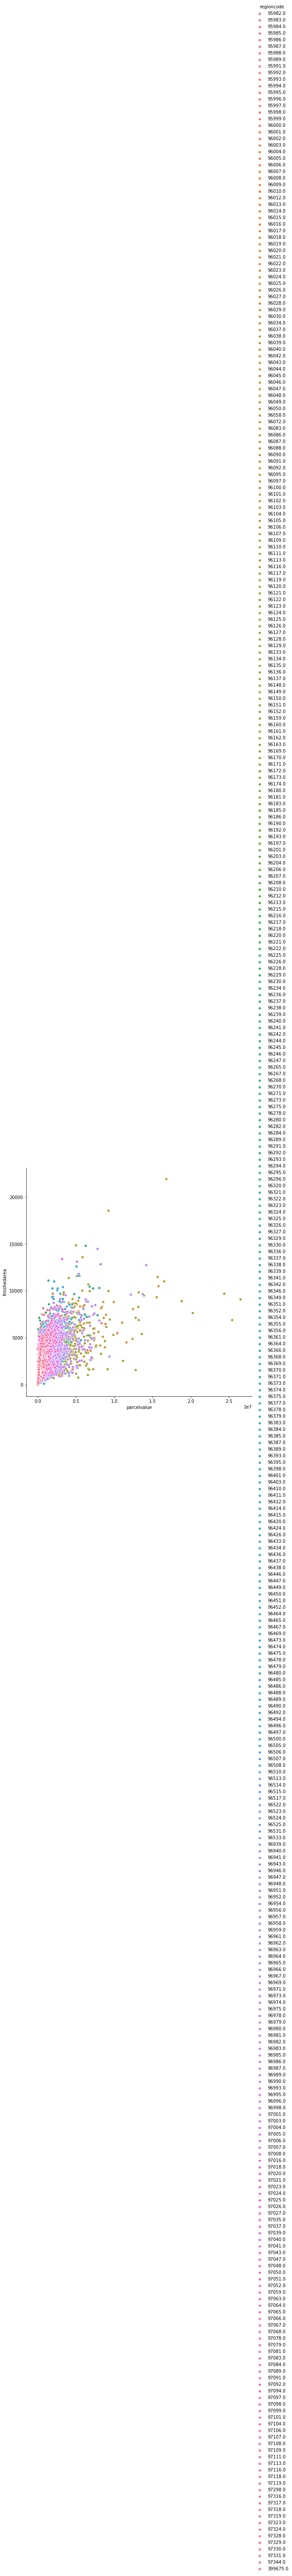

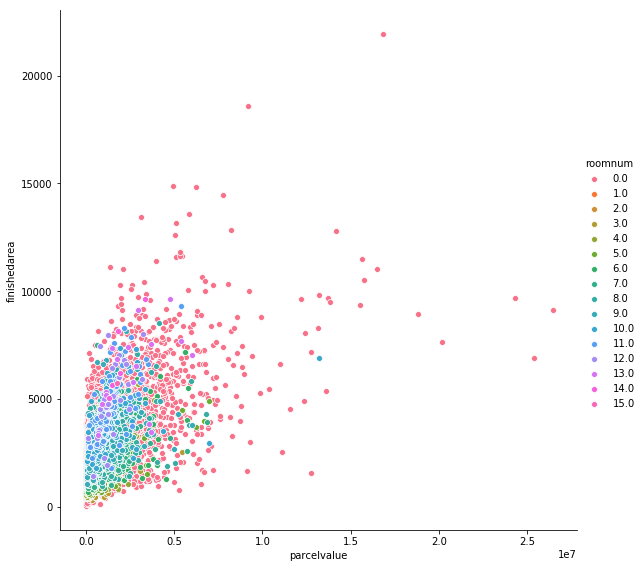

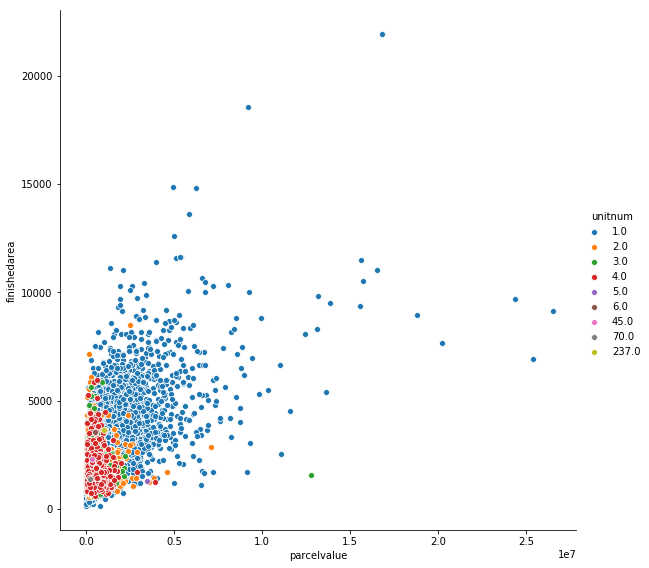

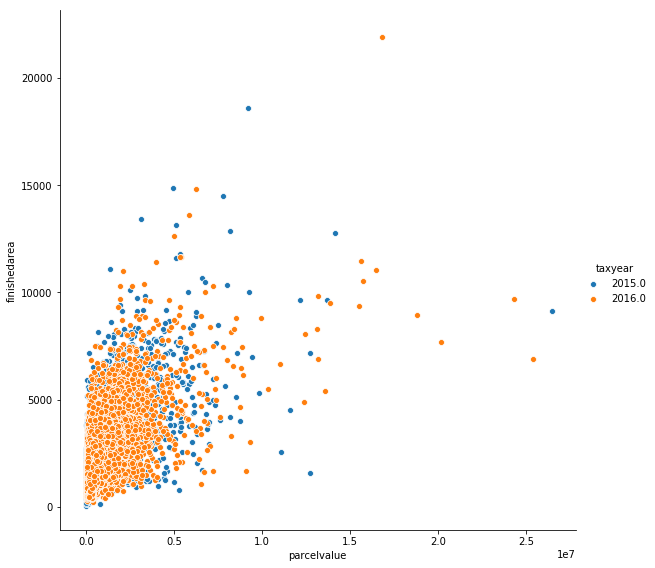

In [32]:
for a in cat_nans:
  sns.pairplot(df_new, hue=a, size=8, x_vars="parcelvalue", y_vars="finishedarea")

***Imputing Cat. Variables***

In [34]:
cat_nans = ['numbath',
 'numbedroom',
 'countycode',
 'numfullbath',
 'citycode',
 'countycode2',
 'regioncode',
 'roomnum',
 'taxyear']
imputer = KNNImputer(weights="distance")
for a in cat_nans:
  df_impute_cat = df_new[[a, "finishedarea", "parcelvalue"]]
  df_new[a] = pd.DataFrame(np.round(imputer.fit_transform(df_impute_cat))).loc[:, 0]

/Users/guneykan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  Depr

***Relationship after imputing, at this point RAM is about to suicide***

/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/guneykan/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg

KeyboardInterrupt: 

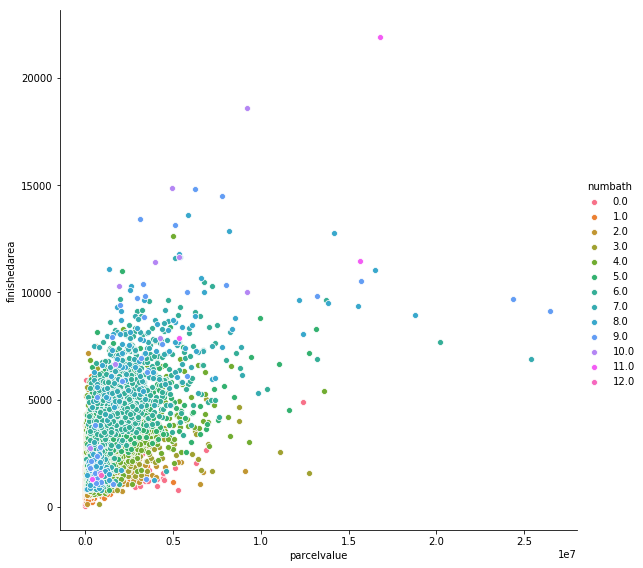

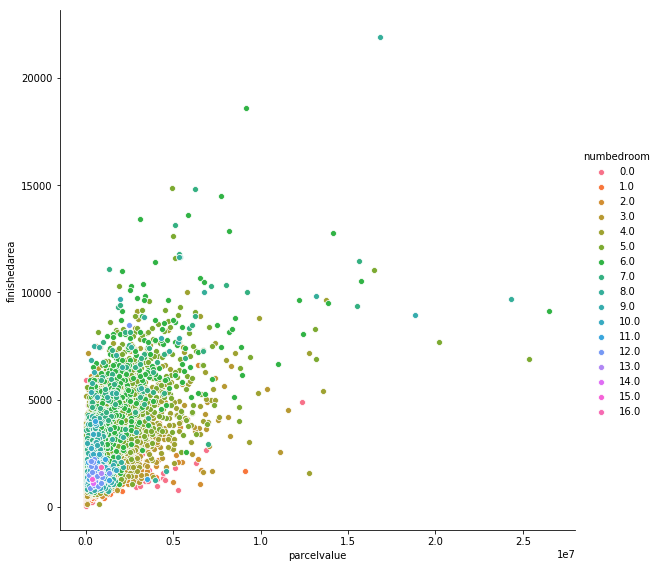

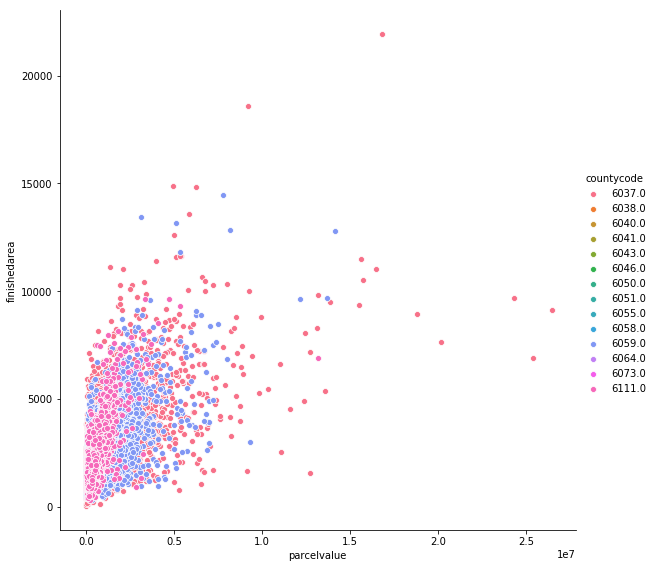

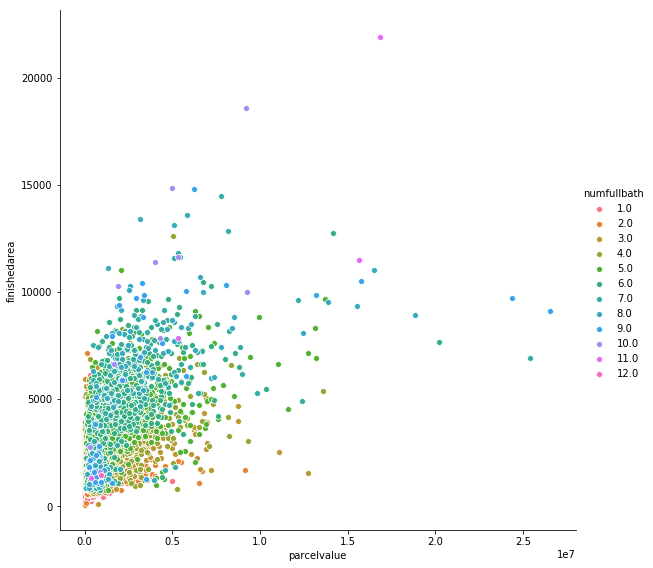

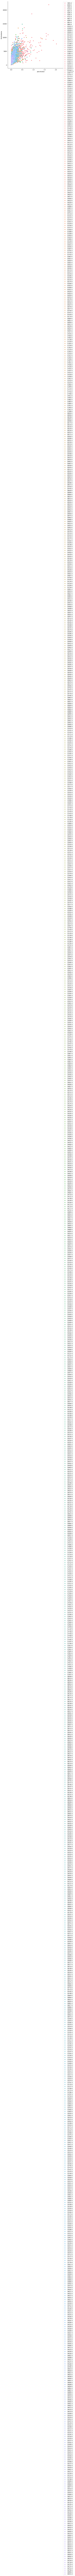

In [35]:
for a in cat_nans:
  sns.pairplot(df_new, hue=a, size=8, x_vars="parcelvalue", y_vars="finishedarea")

## Categorical Data Encoding

### One-hot and Binary

***Note that citycode and regioncode have too many different categories, we will use binary encoding on them, rest of it one-hot-encoding is ok***

In [36]:
df_new.nunique()

lotid           83253
logerror        40316
numbath            13
numbedroom         17
qualitybuild       12
finishedarea     8096
countycode         14
numfireplace        6
numfullbath        12
heatingtype        11
latitude        68398
longitude       66743
lotarea         27594
citycode         1764
countycode2        17
regioncode        423
roomnum            16
unitnum             9
year                2
parcelvalue     57992
taxyear             2
month              12
day                31
dtype: int64

In [37]:
bin_categorical_vars = ["citycode", "regioncode"]
dum_categorical_vars = ["numbath", "numbedroom", "countycode", "numfireplace", "numfullbath", "countycode2", "roomnum", "year", "taxyear"]
encoder = ce.BinaryEncoder(cols=bin_categorical_vars)
df_train = encoder.fit_transform(df_new)

df_train = pd.get_dummies(df_train, columns=dum_categorical_vars)

### Sin-Cos Transformation for recycling VARs. (Month and Day)

In [38]:
columns=['day','month']
for col in columns:
    df_train[col+'_sin']=np.sin((2*np.pi*df_train[col])/max(df_train[col]))
    df_train[col+'_cos']=np.cos((2*np.pi*df_train[col])/max(df_train[col]))

df_train = df_train.drop(columns, axis=1)

## Cont. Vars. Transformation.

### We will remove skewness as much as we can

***We cannot transform log-error easily because it has negative values, avoiding it for now***

In [39]:
cont_vars = ["lotid", "finishedarea", "latitude", "longitude", "lotarea", "parcelvalue"]
df_train[cont_vars].skew()

lotid           33.365553
finishedarea     2.745694
latitude         0.281360
longitude       -0.648437
lotarea         26.077831
parcelvalue     10.252245
dtype: float64

***Log-Trans. for positive skewness***

***Square transformation for negative skewness***

In [40]:
for a in cont_vars:
  if df_train[cont_vars].skew()[a] > 0:
    df_train[a] = np.log(df_train[a])
  else:
    df_train[a] = df_train[a]**2

***Good Improvment***

In [41]:
df_train[cont_vars].skew()

lotid           2.055800
finishedarea    0.396530
latitude        0.259980
longitude       0.657349
lotarea         1.611313
parcelvalue    -0.238494
dtype: float64

***Final Form of the data before Modelling***

In [44]:
df_train.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83944 entries, 0 to 83943
Data columns (total 135 columns):
lotid                 83944 non-null float64
logerror              83944 non-null float64
qualitybuild          53623 non-null float64
finishedarea          83944 non-null float64
heatingtype           52916 non-null float64
latitude              83944 non-null float64
longitude             83944 non-null float64
lotarea               83944 non-null float64
citycode_0            83944 non-null int64
citycode_1            83944 non-null int64
citycode_2            83944 non-null int64
citycode_3            83944 non-null int64
citycode_4            83944 non-null int64
citycode_5            83944 non-null int64
citycode_6            83944 non-null int64
citycode_7            83944 non-null int64
citycode_8            83944 non-null int64
citycode_9            83944 non-null int64
citycode_10           83944 non-null int64
citycode_11           83944 non-null int64
regioncode_0  

In [45]:
df_train = df_train.drop(["heatingtype", "unitnum", "qualitybuild"], axis = 1)

In [46]:
pd.options.display.max_columns = 300
df_train.head()

lotid  logerror  finishedarea   latitude     longitude   lotarea  \
0  16.652049  0.040200      7.164720  17.354834  1.422061e+16  8.674197   
1  16.220432  0.007398      8.073715  17.349573  1.406778e+16  9.839269   
2  16.368794 -0.011369      8.037866  17.340896  1.389817e+16  8.899185   
3  16.482037 -0.015100      8.142645  17.329571  1.384986e+16  9.249561   
4  16.329770  0.008000      6.687109  17.341230  1.396510e+16  7.749753   

   citycode_0  citycode_1  citycode_2  citycode_3  citycode_4  citycode_5  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   citycode_6  citycode_7  citycode_8  citycode_9  citycode_10  citycode_11  \
0           0           0           0           0            0            1   
1           0           0           0           0            1            0   
2           0           0           0           0            1            1   
3           0           0           0           1            0            0   
4           0           0           0           1            0            1   

   regioncode_0  regioncode_1  regioncode_2  regioncode_3  regioncode_4  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   regioncode_5  regioncode_6  regioncode_7  regioncode_8  regioncode_9  \
0             0             0             0             0             1   
1             0             0             0             1             0   
2             0             0             0             1             1   
3             0             0             1             0             0   
4             0             0             1             0             1   

   parcelvalue  numbath_0.0  numbath_1.0  numbath_2.0  numbath_3.0  \
0    12.618791            0            0            1            0   
1    13.607256            0            0            0            1   
2    13.157653            0            0            0            0   
3    13.997832            0            0            0            1   
4    12.322780            0            1            0            0   

   numbath_4.0  numbath_5.0  numbath_6.0  numbath_7.0  numbath_8.0  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            1            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   numbath_9.0  numbath_10.0  numbath_11.0  numbath_12.0  numbedroom_0.0  \
0            0             0             0             0               0   
1            0             0             0             0               0   
2            0             0             0             0               0   
3            0             0             0             0               0   
4            0             0             0             0               0   

   numbedroom_1.0  numbedroom_2.0  numbedroom_3.0  numbedroom_4.0  \
0               0               1               0               0   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               1   
4               0               1               0               0   

  

## Modelling

### Split Data into train and test

***We will have 2 different samples since we do not need to scale for tree based-models but we will scale it for OLS and Lasso***

In [71]:
df_model, df_test = train_test_split(df_train, test_size=0.2, random_state=42)
scl = MinMaxScaler()
X_train_tree = df_model.drop(["parcelvalue"], axis=1).values
y_train = df_model["parcelvalue"].values
X_test_tree = df_test.drop(["parcelvalue"], axis=1).values
y_test = df_test["parcelvalue"].values
X_train = scl.fit_transform(X_train_tree)
X_test = scl.transform(X_test_tree)

### Base Models Lasso - OLS

#### OLS

0.5457261623244954

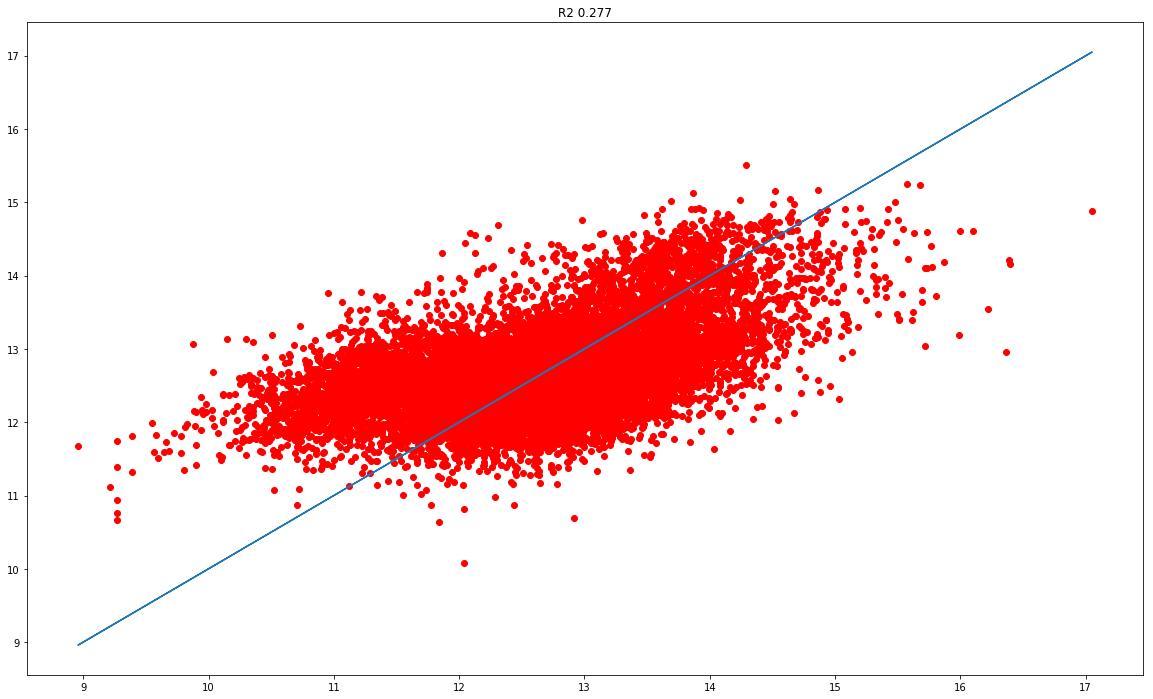

In [74]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_tree, y_train)
reg_pred = lin_reg.predict(X_test_tree)
plt.figure(figsize=(20,12))
plt.scatter(y_test, reg_pred, c="r")
plt.plot(y_test, y_test)
rho_reg = pd.Series(y_test).corr(pd.Series(reg_pred))
plt.title("R2 %.3f" %rho_reg**2)
reg_mse = mean_squared_error(reg_pred, y_test)
reg_mse

#### Lasso

In [50]:
lass = Lasso(random_state=32, max_iter=300000)
alphas = ([0.000007, 0.00002, 0.00004, 0.00005, 0.00008, 0.0001, 0.00012,
                   0.00015, 0.0002, 0.00025, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.002])
params = {"alpha": alphas}
mse = make_scorer(mean_squared_error, greater_is_better=False)
clf = GridSearchCV(lass, params, scoring=mse, cv=2)
clf.fit(X_train, y_train)
clf.best_params_

{'alpha': 5e-05}

0.4687083567565273


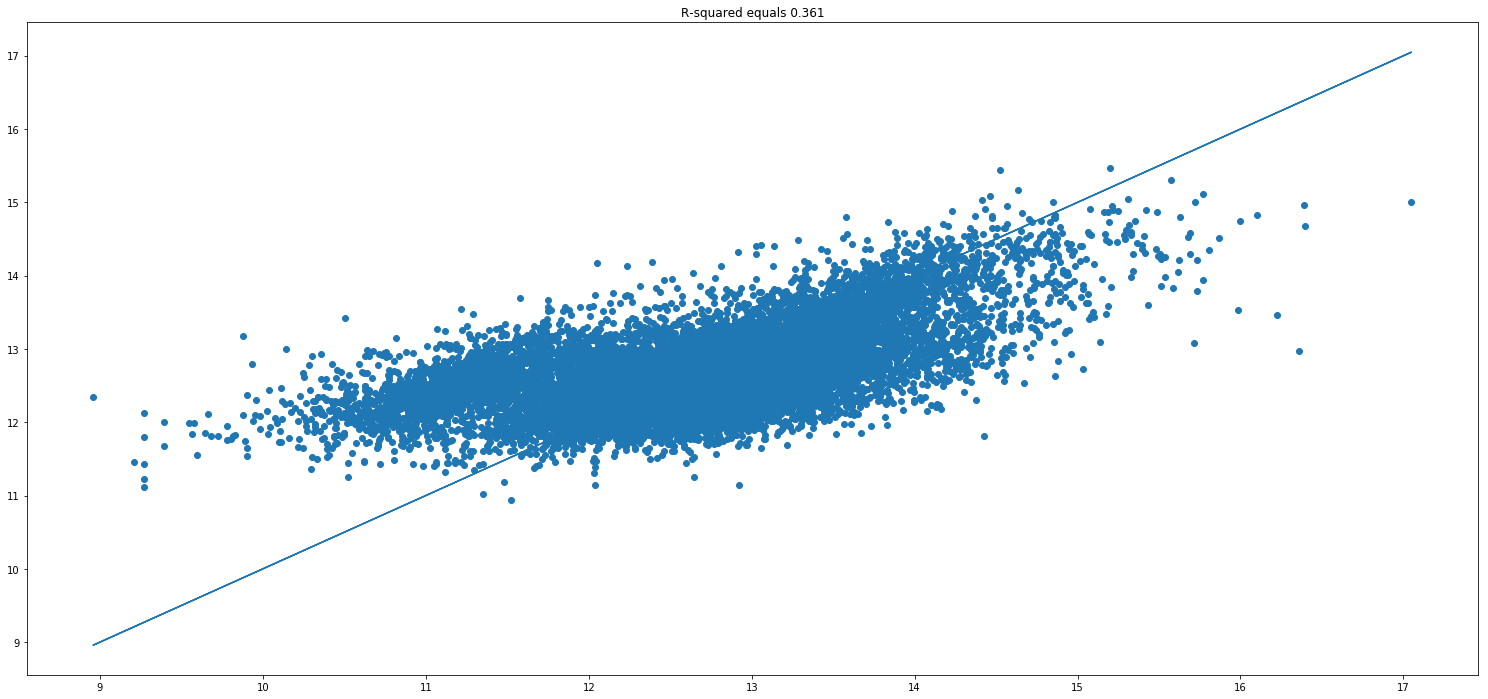

In [73]:
lass = Lasso(alpha=5e-05, max_iter=1000000, warm_start=True)
lass.fit(X_train, y_train)
lass_pred = lass.predict(X_test)
#lass_pred = scl_2.inverse_transform(lass_pred.reshape(-1, 1))
plt.figure(figsize=(26,12))
plt.scatter(x=y_test, y=lass_pred)
plt.plot(y_test, y_test)
rho = pd.Series(y_test).corr(pd.Series(lass_pred.reshape(-1,)))
plt.title('R-squared equals %.3f' %rho**2)
print(mean_squared_error(y_test, lass_pred))

### Trees

#### Random Forrests

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
tree = RandomForestRegressor(random_state=32, n_estimators=50)
max_feat = (np.linspace(2, X_train_tree.shape[1], num=X_train_tree.shape[1]-1, dtype="int64"))
max_dep = (np.linspace(50, 500, num=100, dtype="int64"))
min_samp = (np.linspace(50, 500, num=300, dtype="int64"))
params = {"max_depth": max_dep, "max_features": max_feat, "min_samples_split": min_samp}
mse = make_scorer(mean_squared_error, greater_is_better=False)
rnd = RandomizedSearchCV(tree, params, scoring=mse, cv=2, n_iter=100, refit=True)
rnd.fit(X_train_tree, y_train_tree)
rnd.best_params_

In [75]:
forest = RandomForestRegressor(n_estimators=100, max_depth=490)
forest.fit(X_train_tree, y_train)
for_pred = forest.predict(X_test_tree)

0.4095583191427024

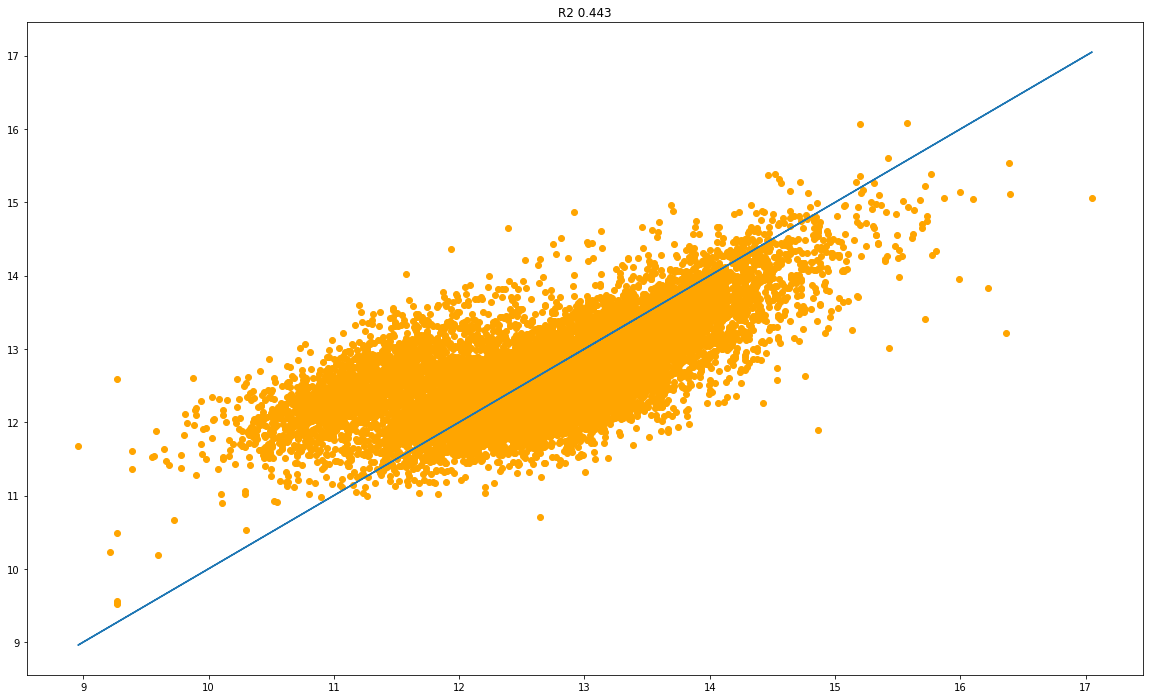

In [76]:
plt.figure(figsize=(20,12))
plt.scatter(y_test, for_pred, c="orange")
plt.plot(y_test, y_test)
rho = pd.Series(y_test).corr(pd.Series(for_pred))
plt.title("R2 %.3f" %rho**2)
for_mse = mean_squared_error(y_test, for_pred)
for_mse

In [ ]:
feature_names = [a if a!="parcelvalue" for a in df_model.columns]
importances = forest.feature_importances_
important_features = pd.Series(data=importances/importances.max() ,index=feature_names)
important_features.sort_values(ascending=False)

### AdaBoost

0.4385033890666866

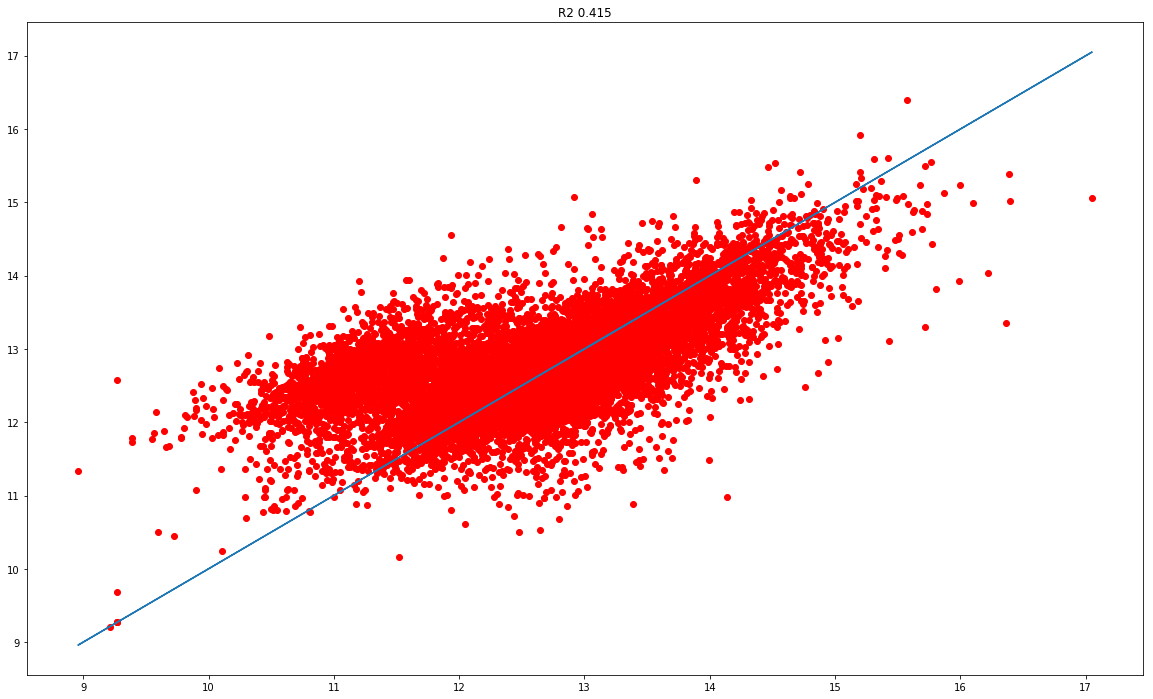

In [77]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=490), n_estimators = 100, loss = "exponential", 
                              learning_rate=0.2)
ada.fit(X_train_tree, y_train)
ada_pred = ada.predict(X_test_tree)
plt.figure(figsize=(20,12))
plt.scatter(y_test, ada_pred, c="r")
plt.plot(y_test, y_test)
rho_ada = pd.Series(y_test).corr(pd.Series(ada_pred))
plt.title("R2 %.3f" %rho_ada**2)
ada_mse = mean_squared_error(ada_pred, y_test)
ada_mse


### GradientBoost - Its not running :(

In [79]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=490, n_estimators = 20, learning_rate = 0.05)
gbrt.fit(X_train_tree, y_train)
gb_pred = gbrt.predict(X_test_tree)
plt.figure(figsize=(20,12))
plt.scatter(y_test, gb_pred, c="r")
plt.plot(y_test, y_test)
rho_gb = pd.Series(y_test).corr(pd.Series(gb_pred))
plt.title("R2 %.3f" %rho_gb**2)
gb_mse = mean_squared_error(gb_pred, y_test)
gb_mse

KeyboardInterrupt: 

### XGBoost

In [82]:
!conda install -c conda-forge xgboost --yes
import xgboost

Solving environment: done

## Package Plan ##

  environment location: /Users/guneykan/anaconda3

  added / updated specs:
    - xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0           8 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    conda-4.8.0                |           py37_1         3.0 MB  conda-forge
    libxgboost-0.90            |       h6de7cb9_1         2.4 MB  conda-forge
    py-xgboost-0.90            |   py37h6de7cb9_1          71 KB  conda-forge
    xgboost-0.90               |   py37h6de7cb9_1           9 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.6 MB

The following NEW packages will be INSTALLED:

  _py-xgboost-mutex  conda-forge/osx-64::_py-xgboost-mutex-2.0-cpu_0
  

In [ ]:
xg = xgboost.XGBRegressor()
colsample = (np.linspace(0.1, 1, num=50, dtype="float16"))
dep = (np.linspace(50, 500, num=100, dtype="int16"))
lr = (np.linspace(0.001, 1, num=100, dtype="float16"))
gamma = (np.linspace(0.001, 0.5, num=60, dtype="float16"))
params = {"max_depth": dep, "colsample_bytree": colsample, "gamma": gamma, "learning_rate": lr}
mse = make_scorer(mean_squared_error, greater_is_better=False)
rnd = RandomizedSearchCV(xg, params, n_jobs=-1, scoring=mse, cv=3, n_iter=20)
rnd.fit(X_train_tree, y_train_tree, eval_set=[(X_test_tree, y_test_tree)], early_stopping_rounds=10)



[23:10:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.1055
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:10.0912
[2]	validation_0-rmse:9.17018
[3]	validation_0-rmse:8.33426
[4]	validation_0-rmse:7.57527
[5]	validation_0-rmse:6.88658
[6]	validation_0-rmse:6.2615
[7]	validation_0-rmse:5.69474
[8]	validation_0-rmse:5.18063
[9]	validation_0-rmse:4.7142
[10]	validation_0-rmse:4.29133
[11]	validation_0-rmse:3.90777
[12]	validation_0-rmse:3.56091
[13]	validation_0-rmse:3.24677
[14]	validation_0-rmse:2.96262
[15]	validation_0-rmse:2.70554
[16]	validation_0-rmse:2.47351
[17]	validation_0-rmse:2.26368
[18]	validation_0-rmse:2.07524
[19]	validation_0-rmse:1.90676
[20]	validation_0-rmse:1.75598
[21]	validation_0-rmse:1.62132
[22]	validation_0-rmse:1.5008
[23]	validation_0-rmse:1.39322
[24]	validation_0-rmse:1.29811
[25]	validation_0-rmse:1.21381
[26]	validation_0-rmse:1.1

0.41657555291428705

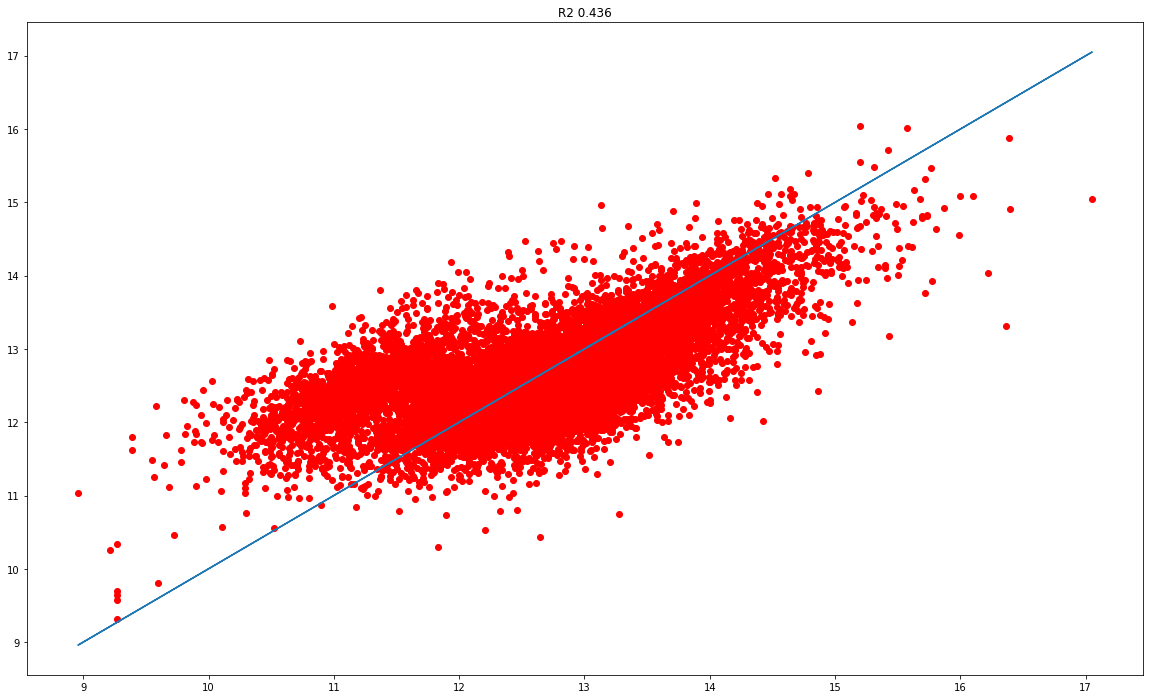

In [84]:
xg = xgboost.XGBRegressor(max_depth=163, colsample_bytree=0.8716, n_estimators = 100, learning_rate=0.0918, gamma=0.466)
xg.fit(X_train_tree, y_train, eval_set=[(X_test_tree, y_test)], early_stopping_rounds=30)
xg_pred = xg.predict(X_test_tree)
plt.figure(figsize=(20,12))
plt.scatter(y_test, xg_pred, c="r")
plt.plot(y_test, y_test)
rho_xg = pd.Series(y_test).corr(pd.Series(xg_pred))
plt.title("R2 %.3f" %rho_xg**2)
xg_mse = mean_squared_error(xg_pred, y_test)
xg_mse

## Averaging Over all Preds.

In [87]:
preds = [ada_pred, xg_pred, reg_pred, lass_pred, y_test]
all_preds = for_pred.reshape(-1, 1)
for a in preds:
  a = np.array(a).reshape(-1, 1)
  all_preds = np.concatenate((all_preds, a), axis=1)

all_preds = pd.DataFrame(all_preds, columns=["for_pred", "ada_pred", "xg_pred", "reg_pred", "lass_pred", "target"])
all_preds.head()


for_pred   ada_pred    xg_pred   reg_pred  lass_pred     target
0  12.792904  12.899240  12.849852  12.996133  12.953716  12.832019
1  12.611772  12.811230  12.693837  12.953379  12.724309  12.858866
2  12.821619  12.809798  12.611650  13.725884  13.368121  13.384728
3  12.375161  12.057805  12.476077  12.475947  12.679264  12.493126
4  12.309568  12.472919  12.455168  12.313882  12.238470  12.425031

0.40920113780321815

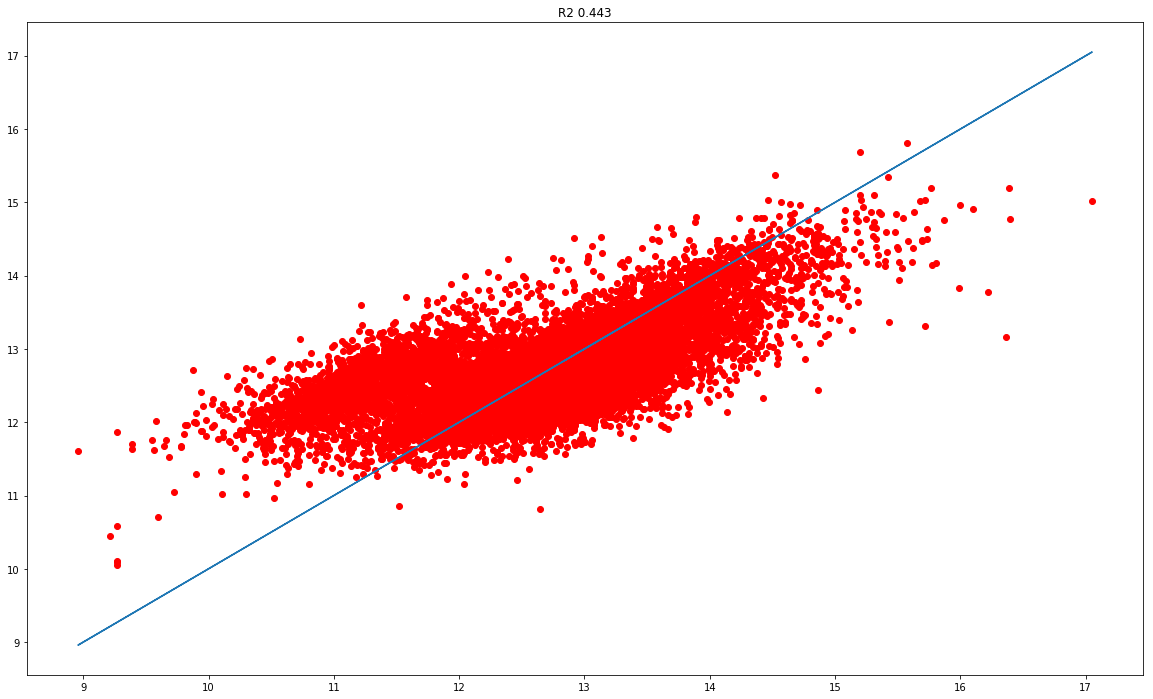

In [89]:
final_pred = np.array(all_preds.drop(["target"], axis=1).mean(axis=1)).reshape(-1,)
plt.figure(figsize=(20,12))
plt.scatter(y_test, final_pred, c="r")
plt.plot(y_test, y_test)
rho_final = pd.Series(y_test).corr(pd.Series(final_pred))
plt.title("R2 %.3f" %rho_final**2)
final_mse = mean_squared_error(final_pred, y_test)
final_mse